# Master EDA - California ACS Person Data

This consolidated notebook combines **ALL** EDA work and visualizations from multiple team members:

<a id='setup'></a>
## 1. Setup and Imports

**Important**
<br>
Step number 1 before you run this notebook: go to ../1_Raw_Data/1_Load_Raw_Data.ipynb and run ONLY the CA section
<br>
This will generate '../1_Raw_Data/data_persons_ca_1yr/persons_master.csv' the csv that we will be working with 
<br>
It is the master csv of data for CA 2018-2024

In [25]:
'''If you dont have these packages already you will need to uncomment these and install'''
#!pip install joypy
#!pip install seaborn

'If you dont have these packages already you will need to uncomment these and install'

In [26]:
# Standard imports
import os, requests, zipfile, io, glob, json, warnings, joypy
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import requests
import json

#Set palletes for visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

#Set up the notebook with the correct data paths
OUTPUT_DIR = 'EDA_data'
os.makedirs(OUTPUT_DIR, exist_ok=True)
DATA_PATH = '../1_Raw_Data/data_persons_ca_1yr/persons_master.csv'
DICT_PATH = f'{OUTPUT_DIR}/suggested_clean_data_dictionary.csv'
TARGET = 'POVPIP'
print(f'Output: {OUTPUT_DIR}')
print('Setup complete!')

Output: EDA_data
Setup complete!


<a id='loading'></a>
## 2. Data Loading

In [27]:
#these column names don't mean very much to us right now 
##we will a look at variables by mapping encoded column names to label

p_file = "../1_Raw_Data/data_persons_ca_1yr/persons_master.csv"
all_headers_persons = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Number of columns:", len(all_headers_persons))
print("First 20 columns:", all_headers_persons[:20])
print("Last 10 columns:", all_headers_persons[-10:])

Number of columns: 275
First 20 columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM']
Last 10 columns: ['PWGTP72', 'PWGTP73', 'PWGTP74', 'PWGTP75', 'PWGTP76', 'PWGTP77', 'PWGTP78', 'PWGTP79', 'PWGTP80', 'year']


<a id='dictionary'></a>
## 3. Data Dictionary

In [28]:
# Here we want to make meaning of the variable names and their definitions
# get column names
p_file = "../1_Raw_Data/data_persons_ca_1yr/persons_master.csv"
cols = pd.read_csv(p_file, nrows=0).columns.tolist()

print("Columns in file:", len(cols))
print("Example columns:", cols[:12])

# fetch Census metadata dictionary
url = "https://api.census.gov/data/2023/acs/acs5/pums/variables.json"
meta = requests.get(url)
meta.raise_for_status()
vardict = meta.json()["variables"]

# mapping each column -> explanation
rows = []
for c in cols:
    info = vardict.get(c, {})
    values_obj = info.get("values")
    rows.append({
        "column": c,
        "label": info.get("label"),
        "predicateType": info.get("predicateType"),
        "values_json": json.dumps(values_obj) if values_obj is not None else None
    })

df_dict = pd.DataFrame(rows)

# save data dict into file path
df_dict.to_csv("EDA_data/all_pums_person_ca_data_dictionary.csv", index=False)
df_dict.head(20) #show first 20 variables

#see the full result of columns mapped to label (column explanation) in EDA_data/all_pums_person_us_data_dictionary.csv

Columns in file: 275
Example columns: ['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW']


,column,label,predicateType,values_json
0,RT,Record Type,string,"{""item"": {""H"": ""Housing Record or Group Quarte..."
1,SERIALNO,Housing unit/GQ person serial number,string,NaN
2,DIVISION,Division code,NaN,"{""item"": {""7"": ""West South Central (South Regi..."
3,SPORDER,Person number,int,"{""range"": [{""min"": ""1"", ""max"": ""20"", ""descript..."
4,PUMA,Public use microdata area code (PUMA) based on...,string,"{""item"": {""00605"": ""Public use microdata area ..."
5,REGION,Region code,NaN,"{""item"": {""1"": ""Northeast"", ""9"": ""Puerto Rico""..."
6,ADJINC,Adjustment factor for income and earnings doll...,int,"{""item"": {""1019518"": ""2023 factor (1.019518 * ..."
7,PWGTP,Person weight,int,"{""range"": [{""min"": ""1"", ""max"": ""9999"", ""descri..."
8,AGEP,Age,int,"{""item"": {""0"": ""Under 1 year""}, ""range"": [{""mi..."
9,CIT,Citizenship status,int,"{""item"": {""2"": ""Born in Puerto Rico, Guam, the..."


In [29]:
'''# as you can see from EDA_data/all_pums_person_us_data_dictionary.csv, not all of these columns are useful
### for example, columns that start with F are all allocation flags i.e. missing information inferred using stat methods
### all columns that start with PWG are person weights are used to produce population estimates from sample data
### we don't need these '''

## dropping useless columns

def is_useless(col):
    if col.startswith("PWG"):      # person weights + replicates
        return True
    if col.startswith("F"):        # allocation flags
        return True
    if col in ["RT", "SERIALNO", "SPORDER"]:  # pure identifiers
        return True
    return False

df_clean = df_dict.loc[~df_dict["column"].apply(is_useless)].copy()

print("Clean dictionary shape:", df_clean.shape)
df_clean.head()

df_clean.to_csv(
    "EDA_data/suggested_clean_data_dictionary.csv",
    index=False
)

print("Saved: suggested_clean_data_dictionary.csv")
# go to suggested_clean_data_dictionary.csv at this point to see new 115 columns 

Clean dictionary shape: (115, 4)
Saved: suggested_clean_data_dictionary.csv


<a id='multi-year'></a>
## 4. Removing Nulls

In [30]:
## 115 variables is still too many, we want to trim down further
# lets try to remove: columns with too many null values, columns of variables that measure the same concept at different resolutions etc. 
import pandas as pd

df = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

print("Starting columns:", df.shape[0])

Starting columns: 115


In [31]:
import pandas as pd

dict_path = "EDA_data/suggested_clean_data_dictionary.csv"
df_dict = pd.read_csv(dict_path)

candidate_cols = df_dict["column"].tolist()
print("Number of candidate columns:", len(candidate_cols))

Number of candidate columns: 115


In [32]:
p_file = "../1_Raw_Data/data_persons_ca_1yr/persons_master.csv"

df = pd.read_csv(
    p_file,
    usecols=candidate_cols
)

print("Shape of loaded data:", df.shape)

null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)

null_summary["pct_null"] = null_summary["n_null"] / len(df)

null_summary = null_summary.sort_values("pct_null", ascending=False)

# load dictionary if not already loaded
df_dict = pd.read_csv(
    "EDA_data/suggested_clean_data_dictionary.csv"
)

# keep only what we need
labels = df_dict[["column", "label"]]

# merge labels into null summary
null_summary = null_summary.merge(
    labels,
    on="column",
    how="left"
)

# reorder columns for readability
null_summary = null_summary[
    ["column", "label", "n_null", "pct_null"]
]


Shape of loaded data: (2322183, 115)


In [33]:
null_summary.head(60)

,column,label,n_null,pct_null
0,GCM,Length of time responsible for grandchildren,2309475,0.994528
1,DRAT,Veteran service connected disability rating (p...,2296137,0.988784
2,GCR,Grandparents responsible for grandchildren,2259588,0.973045
3,SFN,Subfamily number,2217803,0.955051
4,SFR,Subfamily relationship,2217803,0.955051
5,MLPFG,Served February 1955 - July 1964,2216857,0.954644
6,MLPCD,Served May 1975 - July 1990,2216857,0.954644
7,MLPB,Served August 1990 - August 2001 (including Pe...,2216857,0.954644
8,MLPA,Served September 2001 or later,2216857,0.954644
9,MLPE,Served Vietnam era (August 1964 - April 1975),2216857,0.954644


In [34]:
# lets drop any columns that have over 60% null values 

HIGH_NULL_CUTOFF = 0.60

#load current clean dictionary
df_dict = pd.read_csv(dict_path)
candidate_cols = df_dict["column"].tolist()

#load ONLY only cols from the person CSV
df = pd.read_csv(p_file, usecols=candidate_cols)

#compute null rates
null_summary = (
    df.isna()
      .sum()
      .reset_index()
      .rename(columns={"index": "column", 0: "n_null"})
)
null_summary["pct_null"] = null_summary["n_null"] / len(df)

#identify cols with high null values
high_null_cols = null_summary.loc[
    null_summary["pct_null"] >= HIGH_NULL_CUTOFF,
    "column"
].tolist()

print(f"Columns in dict before: {len(candidate_cols)}")
print(f"Dropping (pct_null >= {HIGH_NULL_CUTOFF}): {len(high_null_cols)}")
print("Dropped columns:", high_null_cols)

#trim dict and overwrite same file
df_dict_clean = df_dict.loc[~df_dict["column"].isin(high_null_cols)].copy()
df_dict_clean.to_csv(dict_path, index=False)

print(f"Columns in dict after: {df_dict_clean.shape[0]}")

candidate_cols = df_dict_clean["column"].tolist()
#full list of new columns saved to suggested_clean_data_dictionary.csv

Columns in dict before: 115
Dropping (pct_null >= 0.6): 28
Dropped columns: ['CITWP', 'DRAT', 'DRATX', 'ENG', 'GCM', 'GCR', 'JWMNP', 'JWRIP', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'SCHG', 'YOEP', 'DECADE', 'DRIVESP', 'ESP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'NOP', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR']
Columns in dict after: 87


In [35]:
# intoducing our target variable for poverty -- POVPIP
# Ensure POVPIP is numeric and drop missing values for exploration
povpip = pd.to_numeric(df["POVPIP"], errors="coerce").dropna()

# Basic summary statistics
povpip.describe()


count    2.236197e+06
mean     3.404556e+02
std      1.662664e+02
min      0.000000e+00
25%      1.960000e+02
50%      3.840000e+02
75%      5.010000e+02
max      5.010000e+02
Name: POVPIP, dtype: float64

<a id='target'></a>
## 5. Target Variable (POVPIP)

| Class | POVPIP Range | Description |
|-------|--------------|-------------|
| **Deep Poverty** | 0-50 | Severe hardship |
| **Poverty** | 51-100 | Below poverty |
| **Near Poverty** | 101-200 | Vulnerable |
| **Stable** | 201+ | Secure |

In [36]:
print('Loading data...')
try:
    df = pd.read_csv(DATA_PATH, usecols=candidate_cols)
except:
    df = pd.read_csv(DATA_PATH)
print(f'Shape: {df.shape}, Records: {len(df):,}')

Loading data...
Shape: (2322183, 87), Records: 2,322,183


In [37]:
#defining categoriacal values to our POVPIP variable

def classify_poverty(val):
    if pd.isna(val): return None
    if val <= 50: return 'Deep Poverty'
    if val <= 100: return 'Poverty'
    if val <= 200: return 'Near Poverty'
    return 'Stable'

#create a poverty score
def categorize_poverty_score(val):
    if pd.isna(val): return None
    if val <= 50: return 3
    if val <= 100: return 2
    if val <= 200: return 1
    return 0

df['poverty_class'] = df['POVPIP'].apply(classify_poverty)
df['poverty_risk_score'] = df['POVPIP'].apply(categorize_poverty_score)

CLASS_ORDER = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
CLASS_COLORS = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}
CLASS_COLORS_LIST = [CLASS_COLORS[c] for c in CLASS_ORDER]
print('Classification applied')

Classification applied


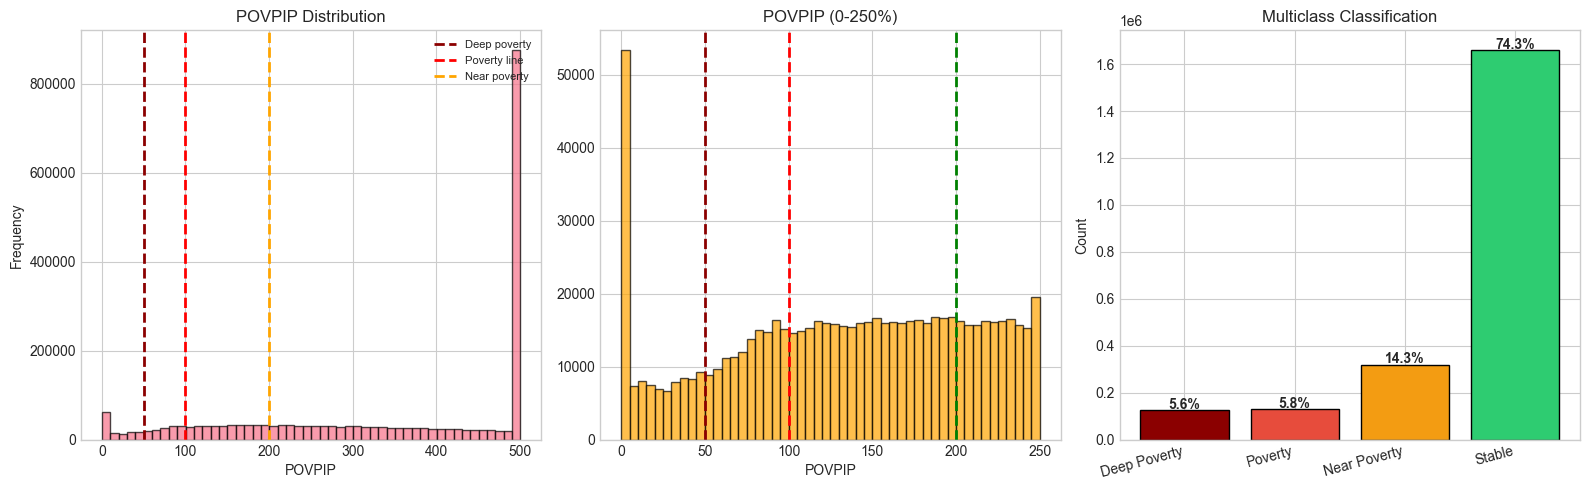


Poverty Breakdown:
  Deep Poverty: 125,723 (5.6%)
  Poverty: 129,920 (5.8%)
  Near Poverty: 320,025 (14.3%)
  Stable: 1,660,529 (74.3%)


In [38]:
# VISUAL 1: POVPIP Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
povpip = df['POVPIP'].dropna()
axes[0].hist(povpip, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='darkred', linestyle='--', lw=2, label='Deep poverty')
axes[0].axvline(x=100, color='red', linestyle='--', lw=2, label='Poverty line')
axes[0].axvline(x=200, color='orange', linestyle='--', lw=2, label='Near poverty')
axes[0].set_xlabel('POVPIP'); axes[0].set_ylabel('Frequency'); axes[0].set_title('POVPIP Distribution')
axes[0].legend(fontsize=8)
axes[1].hist(povpip[povpip<=250], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=50, color='darkred', linestyle='--', lw=2)
axes[1].axvline(x=100, color='red', linestyle='--', lw=2)
axes[1].axvline(x=200, color='green', linestyle='--', lw=2)
axes[1].set_xlabel('POVPIP'); axes[1].set_title('POVPIP (0-250%)')
class_counts = df['poverty_class'].value_counts().reindex(CLASS_ORDER)
bars = axes[2].bar(CLASS_ORDER, class_counts.values, color=CLASS_COLORS_LIST, edgecolor='black')
axes[2].set_ylabel('Count'); axes[2].set_title('Multiclass Classification')
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=15, ha='right')
total_valid = df['poverty_class'].notna().sum()
for bar, cnt in zip(bars, class_counts.values):
    axes[2].text(bar.get_x()+bar.get_width()/2, bar.get_height()+5000, f'{cnt/total_valid*100:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/povpip_distribution_multiclass.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'\nPoverty Breakdown:')
for cls in CLASS_ORDER: print(f'  {cls}: {class_counts[cls]:,} ({class_counts[cls]/total_valid*100:.1f}%)')

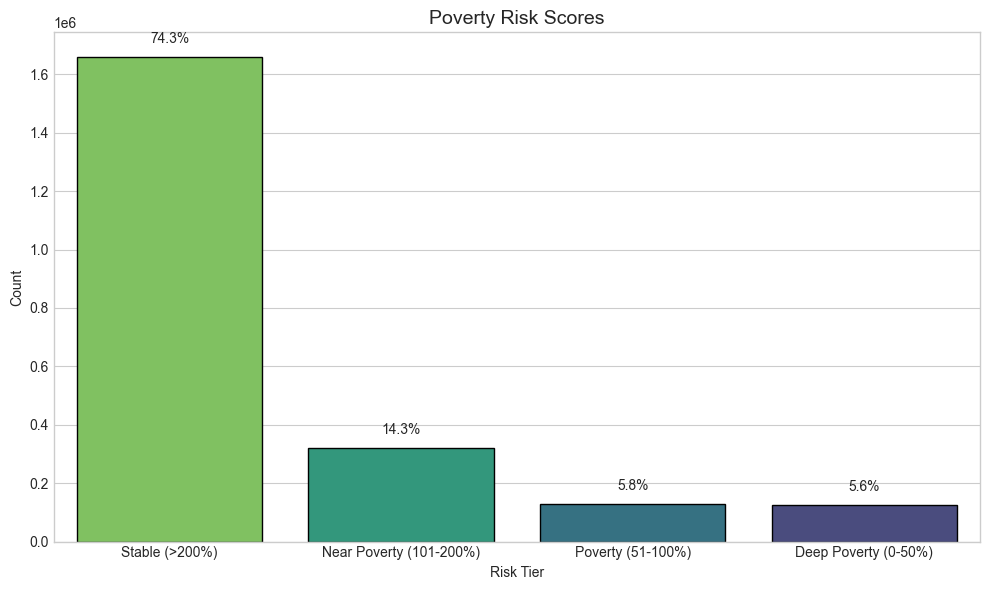

In [39]:
# VISUAL 2: Poverty Risk Score Countplot
plt.figure(figsize=(10, 6))
labels = ['Stable (>200%)', 'Near Poverty (101-200%)', 'Poverty (51-100%)', 'Deep Poverty (0-50%)']
ax = sns.countplot(data=df, x='poverty_risk_score', palette='viridis_r', edgecolor='black')
plt.title('Poverty Risk Scores', fontsize=14); plt.xlabel('Risk Tier'); plt.ylabel('Count')
plt.xticks(ticks=[0,1,2,3], labels=labels)
total = len(df.dropna(subset=['poverty_risk_score']))
for p in ax.patches:
    ax.annotate(f'{100*p.get_height()/total:.1f}%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', xytext=(0,10), textcoords='offset points')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_risk_bins.png', dpi=150)
plt.show()

<a id='correlation'></a>
## 6. Correlation Analysis

In [40]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in ['POVPIP', 'poverty_risk_score']]
df_valid = df[df['POVPIP'].notna()].copy()
correlations = {}
for col in feature_cols:
    col_data = df_valid[col].dropna()
    if len(col_data) < 100 or col_data.nunique() <= 1: continue
    povpip_matched = df_valid.loc[col_data.index, 'POVPIP']
    col_std = (col_data - col_data.mean()) / (col_data.std() + 1e-10)
    pov_std = (povpip_matched - povpip_matched.mean()) / (povpip_matched.std() + 1e-10)
    try:
        corr, pval = stats.pearsonr(col_std, pov_std)
        if not np.isnan(corr): correlations[col] = {'correlation': corr, 'p_value': pval, 'abs_corr': abs(corr)}
    except: pass
corr_df = pd.DataFrame(correlations).T.sort_values('abs_corr', ascending=False).reset_index().rename(columns={'index': 'column'})
if 'column' in df_dict_clean.columns and 'label' in df_dict_clean.columns:
    corr_df = corr_df.merge(df_dict_clean[['column', 'label']], on='column', how='left')
    corr_df['short_label'] = corr_df['label'].apply(lambda x: str(x)[:45]+'...' if pd.notna(x) and len(str(x))>45 else str(x))
else:
    corr_df['short_label'] = corr_df['column']
print('Top 30 Correlations:')
for i, row in corr_df.head(30).iterrows(): print(f"{row['column']:12} | r={row['correlation']:+.3f} | {row['short_label']}")

Top 30 Correlations:
PRIVCOV      | r=-0.469 | Private health insurance coverage recode
HINS4        | r=+0.456 | Medicaid, Medical Assistance, or any kind of ...
HINS1        | r=-0.437 | Insurance through a current or former employe...
PINCP        | r=+0.418 | Total person's income (use ADJINC to adjust t...
PERNP        | r=+0.372 | Total person's earnings (use ADJINC to adjust...
WAGP         | r=+0.363 | Wages or salary income past 12 months (use AD...
PUBCOV       | r=+0.351 | Public health coverage recode
OCCP         | r=-0.284 | Occupation recode for 2018 and later based on...
WRK          | r=-0.266 | Worked last week
SCHL         | r=+0.262 | Educational attainment
ESR          | r=-0.250 | Employment status recode
WKL          | r=-0.245 | When last worked
MSP          | r=-0.244 | Married, spouse present/spouse absent
MAR          | r=-0.218 | Marital status
WKHP         | r=+0.217 | Usual hours worked per week past 12 months
NWLK         | r=+0.210 | Looking for work (UN

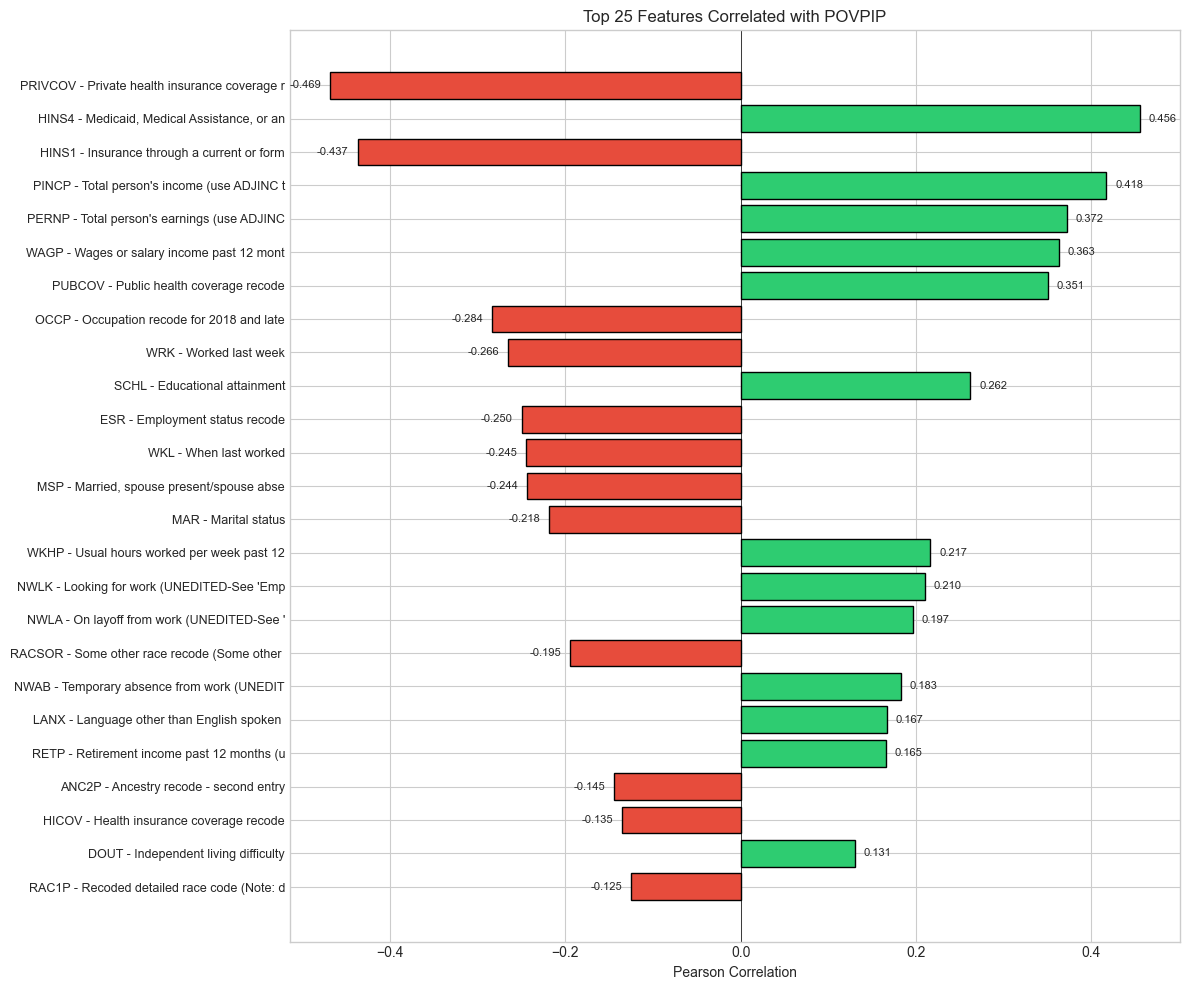

In [41]:
# VISUAL 3: Correlation Bar Chart
top_n = 25
top_corr = corr_df.head(top_n).copy()
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_corr['correlation']]
y_labels = [f"{row['column']} - {str(row.get('short_label',''))[:35]}" for _, row in top_corr.iterrows()]
ax.barh(range(len(top_corr)), top_corr['correlation'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_corr))); ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Pearson Correlation'); ax.set_title(f'Top {top_n} Features Correlated with POVPIP')
ax.axvline(x=0, color='black', lw=0.5); ax.invert_yaxis()
for i, row in top_corr.iterrows():
    ax.text(row['correlation']+0.01 if row['correlation']>0 else row['correlation']-0.01, i, f"{row['correlation']:.3f}", va='center', ha='left' if row['correlation']>0 else 'right', fontsize=8)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/correlation_with_povpip.png', dpi=150, bbox_inches='tight')
plt.show()

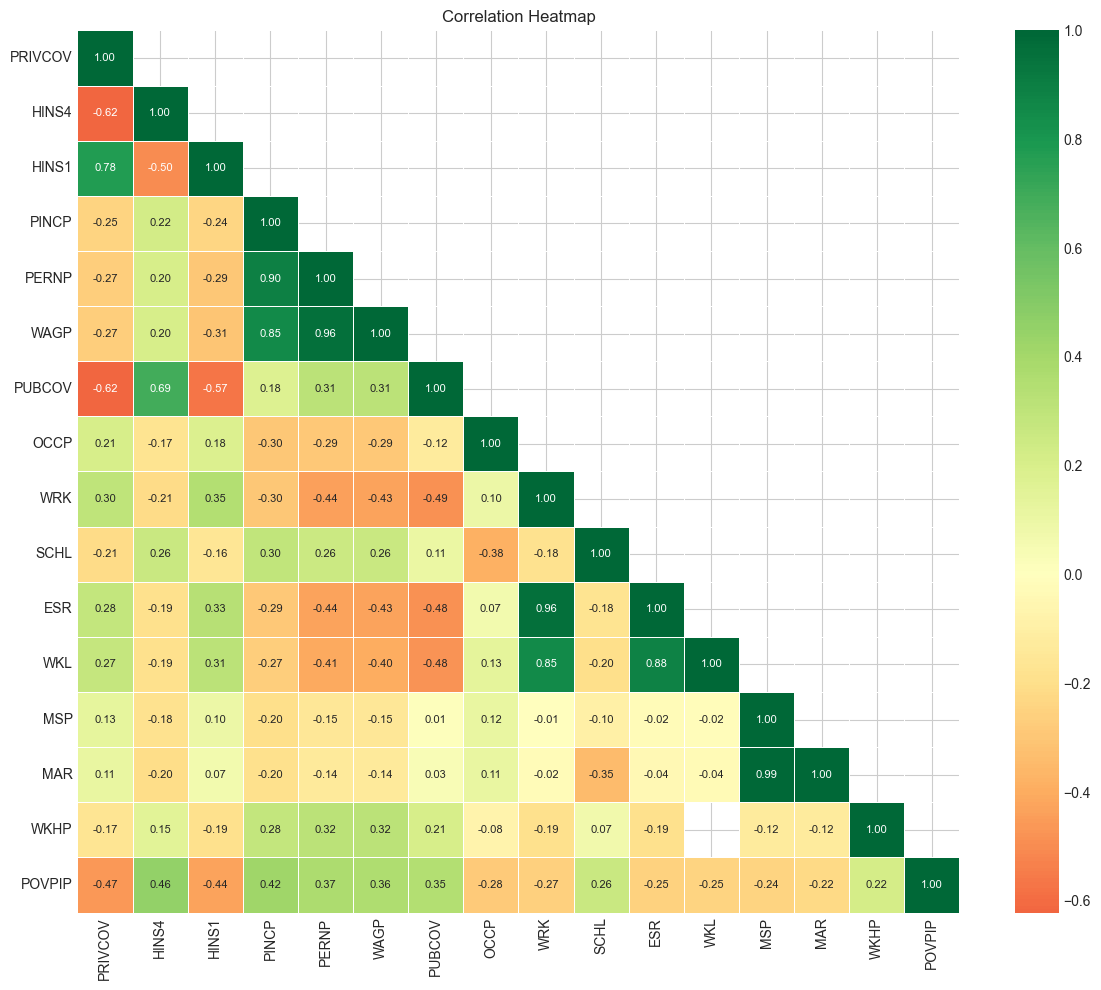

In [42]:
# VISUAL 4: Correlation Heatmap
top_features = corr_df.head(15)['column'].tolist() + ['POVPIP']
top_features = [f for f in top_features if f in df_valid.columns]
corr_matrix = df_valid[top_features].corr()
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', linewidths=0.5, ax=ax, mask=mask, annot_kws={'size': 8})
ax.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

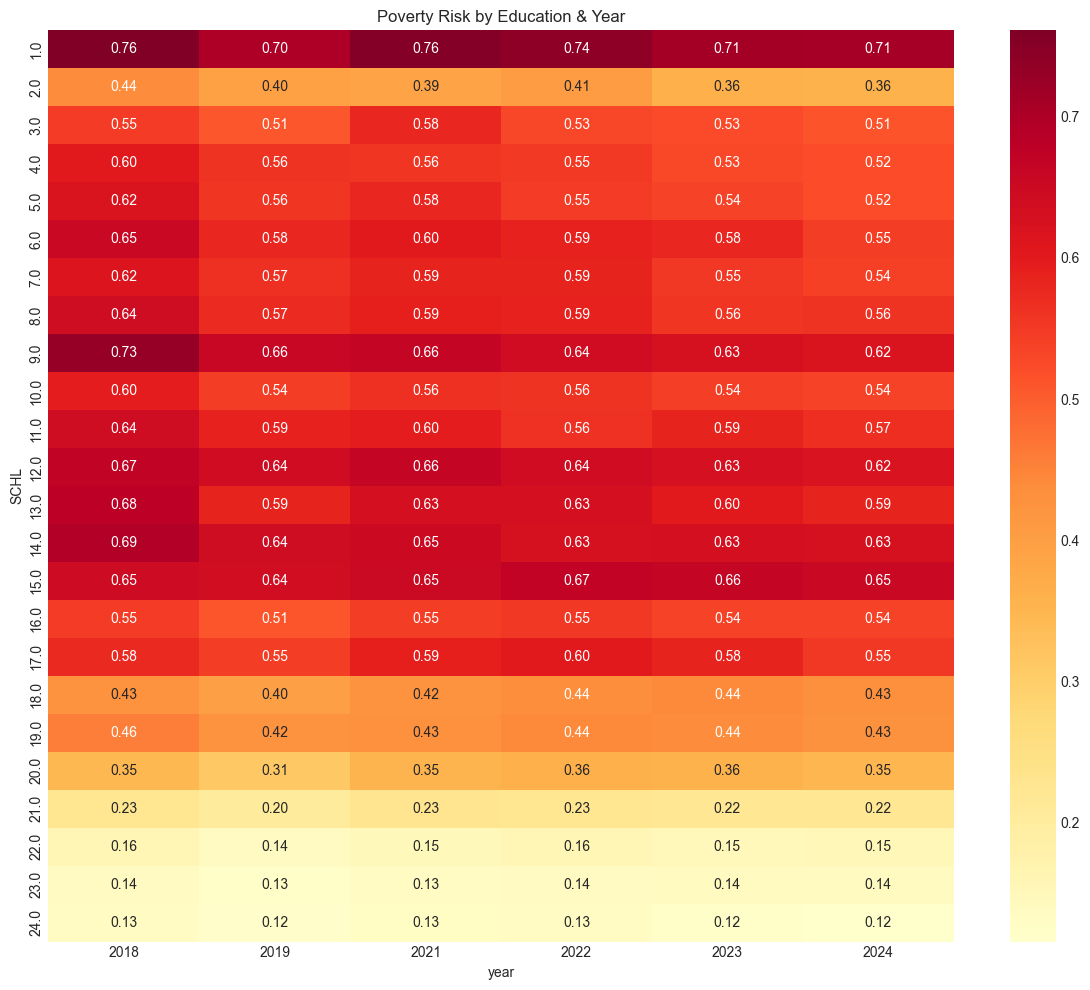

In [43]:
# VISUAL 5: Education vs Poverty Risk by Year
year_col = 'year' if 'year' in df.columns else 'SURVEY_YEAR' if 'SURVEY_YEAR' in df.columns else None
if year_col and df[year_col].nunique() > 1:
    pivot = df.pivot_table(index='SCHL', columns=year_col, values='poverty_risk_score', aggfunc='mean')
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Poverty Risk by Education & Year')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/education_poverty_heatmap_years.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Multi-year heatmap skipped')

<a id='variance'></a>
## 7. Variance Analysis

In [44]:
variance_stats = []
for col in feature_cols:
    if col in df.columns:
        col_data = df[col].dropna()
        if len(col_data) > 0:
            variance_stats.append({'column': col, 'variance': col_data.var(), 'unique_values': col_data.nunique(), 'mode_pct': col_data.value_counts(normalize=True).iloc[0]*100})
variance_df = pd.DataFrame(variance_stats).sort_values('mode_pct', ascending=False)
low_var = variance_df[variance_df['mode_pct'] > 95]
print(f'Low Variance (mode>95%): {len(low_var)}')
print(low_var[['column', 'mode_pct', 'unique_values']].head(15).to_string())

Low Variance (mode>95%): 19
      column    mode_pct  unique_values
0   DIVISION  100.000000              1
2     REGION  100.000000              1
76     RACNH   99.768838              2
20     HINS7   99.580912              2
66     POWSP   99.568870             58
78     RACPI   99.435531              2
24     MARHD   99.124227              2
27     MARHW   99.098594              2
19     HINS6   98.240320              2
37       PAP   98.149447            314
25     MARHM   97.690816              2
18     HINS5   97.668056              2
9       DEYE   97.607639              2
73   RACAIAN   96.767481              2
43      SSIP   96.622659            239


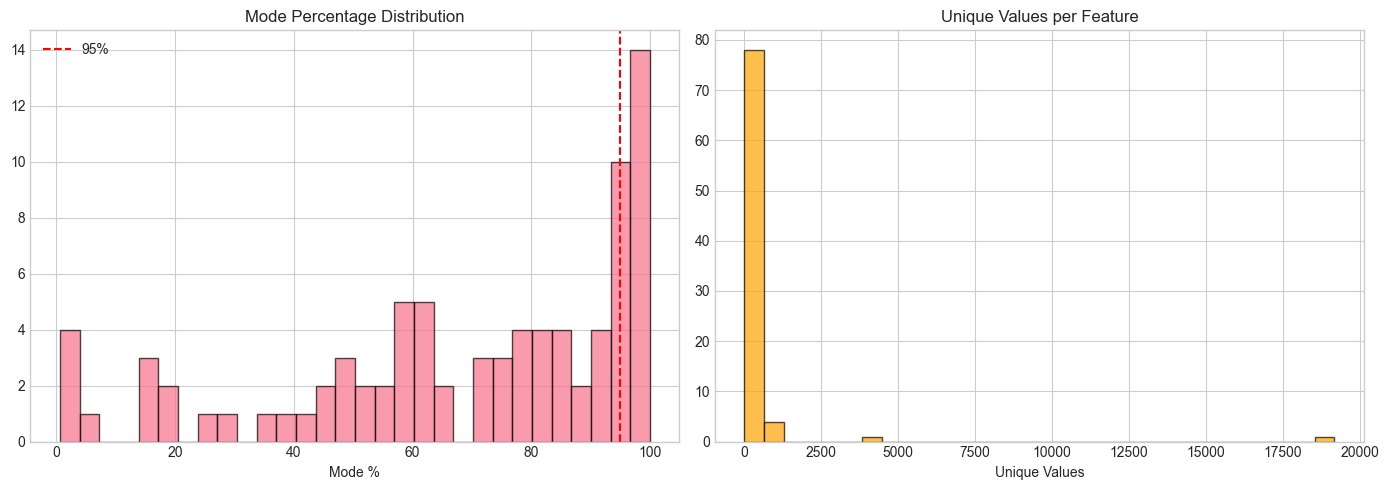

In [45]:
# VISUAL 6: Variance Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(variance_df['mode_pct'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=95, color='red', linestyle='--', label='95%')
axes[0].set_xlabel('Mode %'); axes[0].set_title('Mode Percentage Distribution'); axes[0].legend()
axes[1].hist(variance_df['unique_values'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Unique Values'); axes[1].set_title('Unique Values per Feature')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/variance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

<a id='demographics'></a>
## 8. Demographics

In [46]:
df_analysis = df[df['poverty_class'].notna()].copy()
print(f'Records for analysis: {len(df_analysis):,}')

Records for analysis: 2,236,197


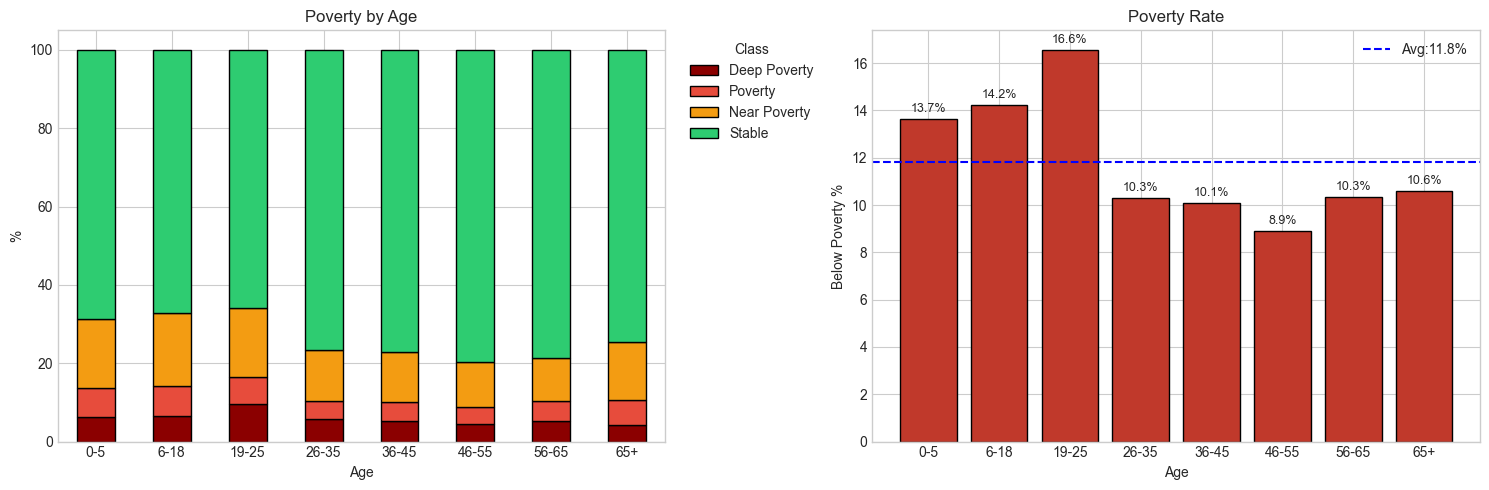

In [47]:
# VISUAL 7: Age
def cat_age(age):
    if pd.isna(age): return None
    if age<=5: return '0-5'
    if age<=18: return '6-18'
    if age<=25: return '19-25'
    if age<=35: return '26-35'
    if age<=45: return '36-45'
    if age<=55: return '46-55'
    if age<=65: return '56-65'
    return '65+'
df_analysis['age_group'] = df_analysis['AGEP'].apply(cat_age)
age_dist = df_analysis.dropna(subset=['age_group']).groupby(['age_group', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
age_pct = age_dist.div(age_dist.sum(axis=1), axis=0)*100
age_pct = age_pct.reindex(['0-5','6-18','19-25','26-35','36-45','46-55','56-65','65+'])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
age_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('Age'); axes[0].set_ylabel('%'); axes[0].set_title('Poverty by Age')
axes[0].legend(title='Class', bbox_to_anchor=(1.02,1)); axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
vuln = age_pct['Deep Poverty']+age_pct['Poverty']
bars = axes[1].bar(vuln.index, vuln.values, color='#c0392b', edgecolor='black')
axes[1].set_xlabel('Age'); axes[1].set_ylabel('Below Poverty %'); axes[1].set_title('Poverty Rate')
axes[1].axhline(y=vuln.mean(), color='blue', linestyle='--', label=f'Avg:{vuln.mean():.1f}%')
axes[1].legend()
for b,r in zip(bars, vuln.values): axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.3, f'{r:.1f}%', ha='center', fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

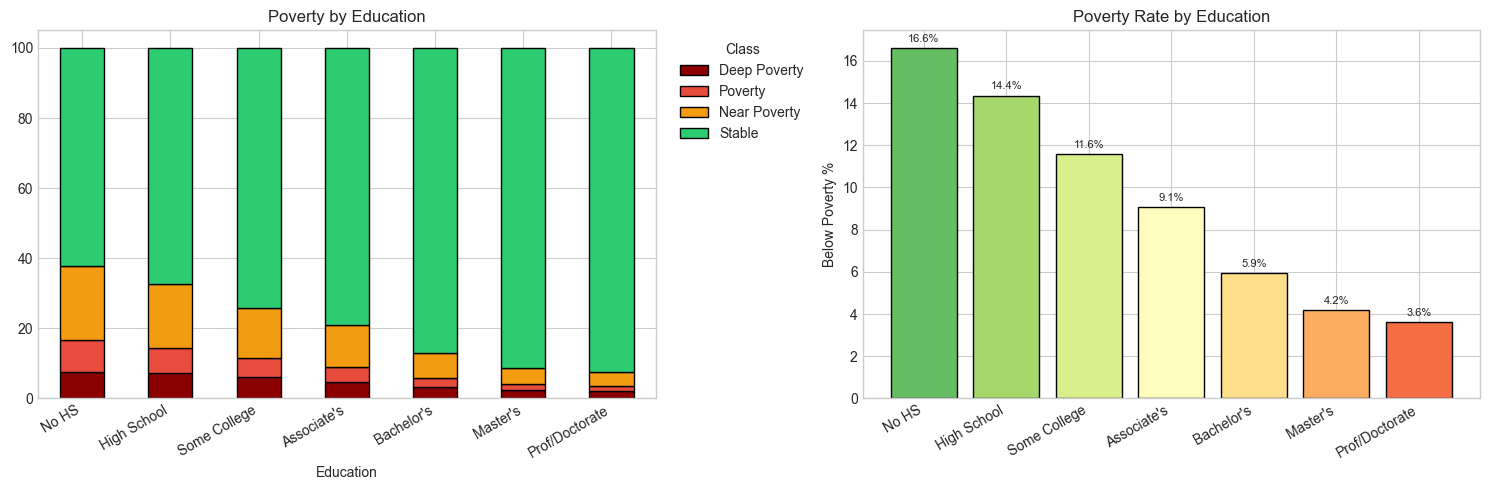

In [48]:
# VISUAL 8: Education
def cat_edu(schl):
    if pd.isna(schl): return None
    if schl<=15: return 'No HS'
    if schl<=17: return 'High School'
    if schl<=19: return 'Some College'
    if schl==20: return "Associate's"
    if schl==21: return "Bachelor's"
    if schl==22: return "Master's"
    return 'Prof/Doctorate'
df_analysis['education'] = df_analysis['SCHL'].apply(cat_edu)
edu_dist = df_analysis.dropna(subset=['education']).groupby(['education', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
edu_pct = edu_dist.div(edu_dist.sum(axis=1), axis=0)*100
edu_order = ['No HS', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Prof/Doctorate']
edu_pct = edu_pct.reindex([e for e in edu_order if e in edu_pct.index])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
edu_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('Education'); axes[0].set_title('Poverty by Education')
axes[0].legend(title='Class', bbox_to_anchor=(1.02,1))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=30, ha='right')
vuln = edu_pct['Deep Poverty']+edu_pct['Poverty']
colors_grad = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vuln)))
bars = axes[1].bar(range(len(vuln)), vuln.values, color=colors_grad, edgecolor='black')
axes[1].set_xticks(range(len(vuln))); axes[1].set_xticklabels(vuln.index, rotation=30, ha='right')
axes[1].set_ylabel('Below Poverty %'); axes[1].set_title('Poverty Rate by Education')
for b,r in zip(bars, vuln.values): axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.3, f'{r:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_education.png', dpi=150, bbox_inches='tight')
plt.show()

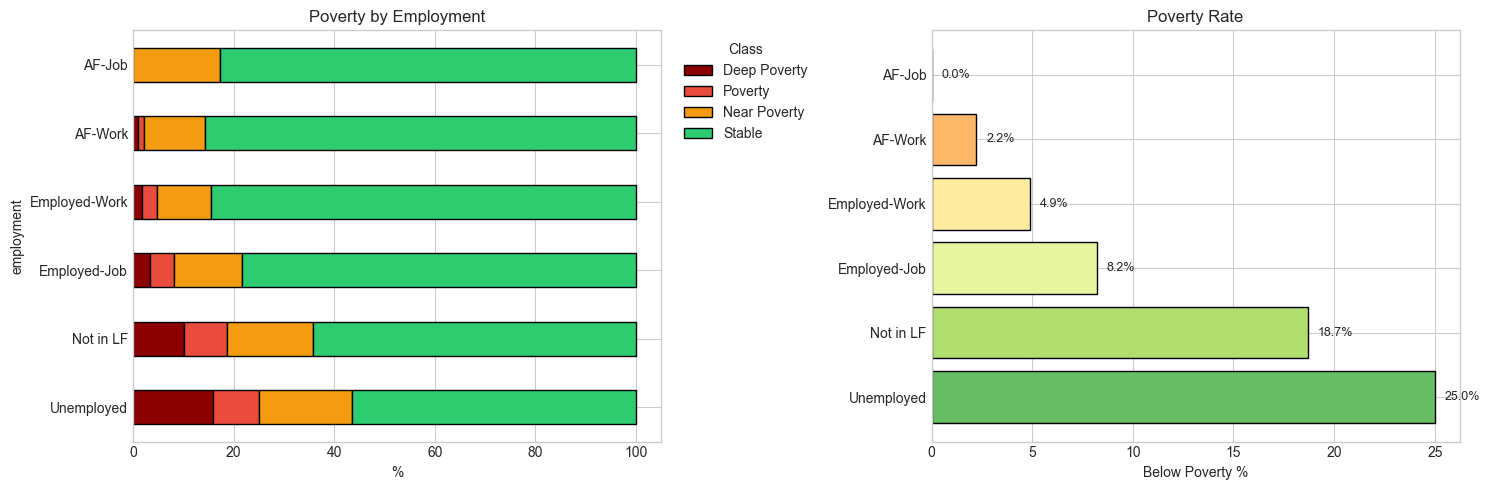

In [49]:
# VISUAL 9: Employment
emp_map = {1:'Employed-Work',2:'Employed-Job',3:'Unemployed',4:'AF-Work',5:'AF-Job',6:'Not in LF'}
df_analysis['employment'] = df_analysis['ESR'].map(emp_map)
emp_dist = df_analysis.dropna(subset=['employment']).groupby(['employment', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
emp_pct = emp_dist.div(emp_dist.sum(axis=1), axis=0)*100
vuln = emp_pct['Deep Poverty']+emp_pct['Poverty']
emp_pct = emp_pct.loc[vuln.sort_values(ascending=False).index]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
emp_pct.plot(kind='barh', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('%'); axes[0].set_title('Poverty by Employment'); axes[0].legend(title='Class', bbox_to_anchor=(1.02,1))
vuln_sorted = vuln.sort_values(ascending=False)
colors_grad = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vuln_sorted)))
bars = axes[1].barh(range(len(vuln_sorted)), vuln_sorted.values, color=colors_grad, edgecolor='black')
axes[1].set_yticks(range(len(vuln_sorted))); axes[1].set_yticklabels(vuln_sorted.index)
axes[1].set_xlabel('Below Poverty %'); axes[1].set_title('Poverty Rate')
for b,r in zip(bars, vuln_sorted.values): axes[1].text(b.get_width()+0.5, b.get_y()+b.get_height()/2, f'{r:.1f}%', va='center', fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_employment.png', dpi=150, bbox_inches='tight')
plt.show()

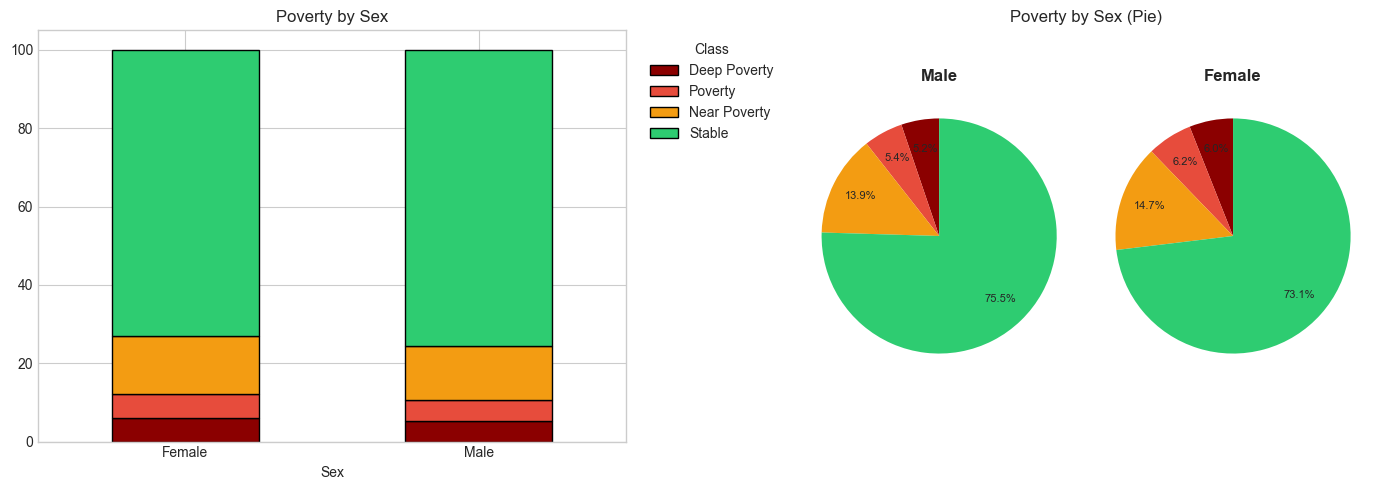

In [50]:
# VISUAL 10: Sex
df_analysis['sex'] = df_analysis['SEX'].map({1:'Male',2:'Female'})
sex_dist = df_analysis.dropna(subset=['sex']).groupby(['sex', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
sex_pct = sex_dist.div(sex_dist.sum(axis=1), axis=0)*100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sex_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('Sex'); axes[0].set_title('Poverty by Sex'); axes[0].legend(title='Class', bbox_to_anchor=(1.02,1))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
for i, sex in enumerate(['Male', 'Female']):
    ax_pie = axes[1].inset_axes([i*0.5, 0, 0.5, 1])
    data = sex_dist.loc[sex]
    wedges, texts, autotexts = ax_pie.pie(data, autopct='%1.1f%%', colors=CLASS_COLORS_LIST, startangle=90, pctdistance=0.75)
    ax_pie.set_title(sex, fontweight='bold')
    for at in autotexts: at.set_fontsize(8)
axes[1].axis('off'); axes[1].set_title('Poverty by Sex (Pie)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_sex.png', dpi=150, bbox_inches='tight')
plt.show()

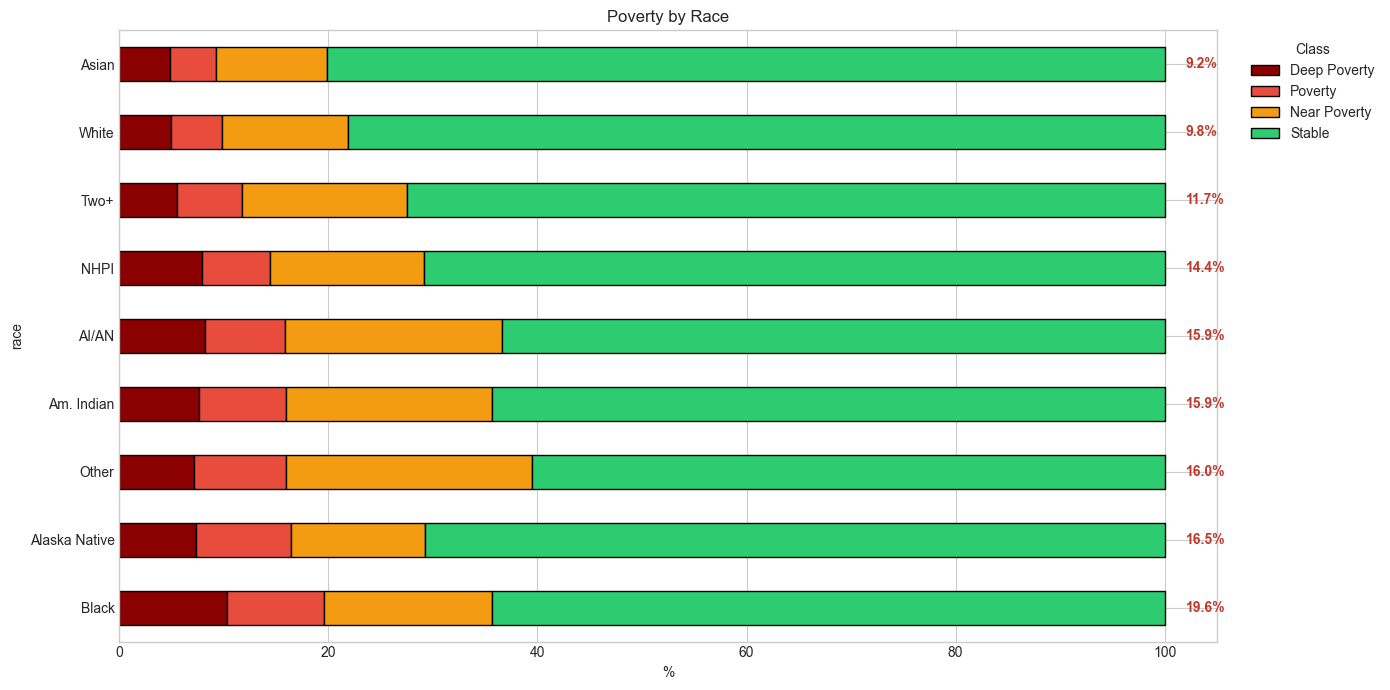

In [51]:
# VISUAL 11: Race
race_map = {1:'White',2:'Black',3:'Am. Indian',4:'Alaska Native',5:'AI/AN',6:'Asian',7:'NHPI',8:'Other',9:'Two+'}
df_analysis['race'] = df_analysis['RAC1P'].map(race_map)
race_dist = df_analysis.dropna(subset=['race']).groupby(['race', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
race_pct = race_dist.div(race_dist.sum(axis=1), axis=0)*100
vuln = race_pct['Deep Poverty']+race_pct['Poverty']
race_pct = race_pct.loc[vuln.sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(14, 7))
race_pct.plot(kind='barh', stacked=True, ax=ax, color=CLASS_COLORS_LIST, edgecolor='black')
ax.set_xlabel('%'); ax.set_title('Poverty by Race'); ax.legend(title='Class', bbox_to_anchor=(1.02,1))
for i, (idx, row) in enumerate(race_pct.iterrows()):
    v = row['Deep Poverty']+row['Poverty']
    ax.text(102, i, f'{v:.1f}%', va='center', fontweight='bold', color='#c0392b')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_race.png', dpi=150, bbox_inches='tight')
plt.show()

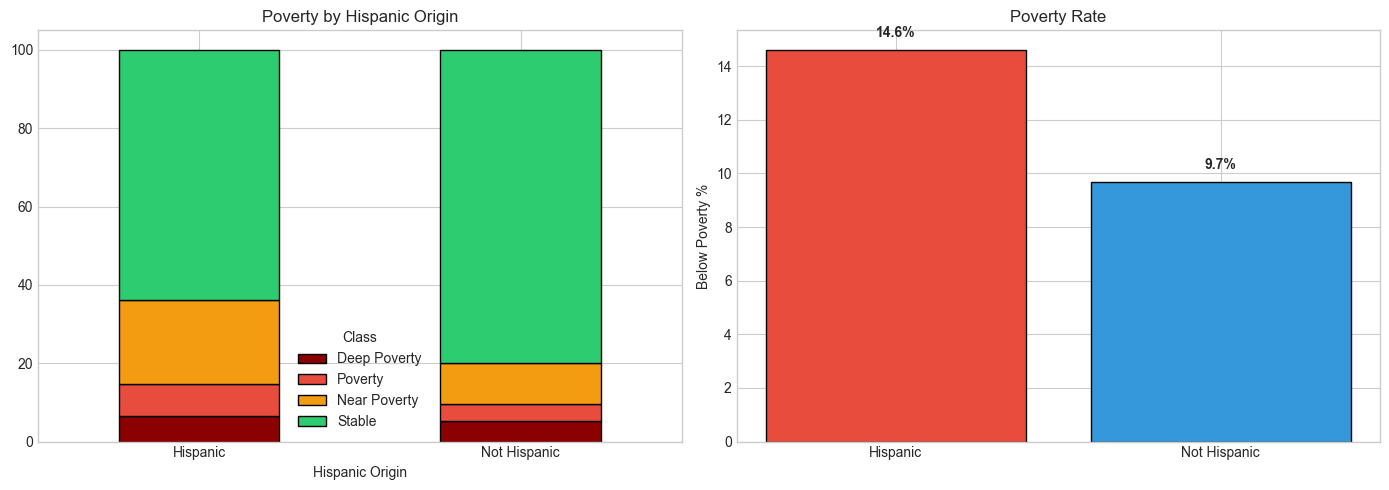

In [52]:
# VISUAL 12: Hispanic
df_analysis['hispanic'] = df_analysis['HISP'].apply(lambda x: 'Hispanic' if x>1 else 'Not Hispanic')
hisp_dist = df_analysis.dropna(subset=['hispanic']).groupby(['hispanic', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
hisp_pct = hisp_dist.div(hisp_dist.sum(axis=1), axis=0)*100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
hisp_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('Hispanic Origin'); axes[0].set_title('Poverty by Hispanic Origin'); axes[0].legend(title='Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
vuln = hisp_pct['Deep Poverty']+hisp_pct['Poverty']
bars = axes[1].bar(vuln.index, vuln.values, color=['#e74c3c','#3498db'], edgecolor='black')
axes[1].set_ylabel('Below Poverty %'); axes[1].set_title('Poverty Rate')
for b,r in zip(bars, vuln.values): axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f'{r:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_hispanic.png', dpi=150, bbox_inches='tight')
plt.show()

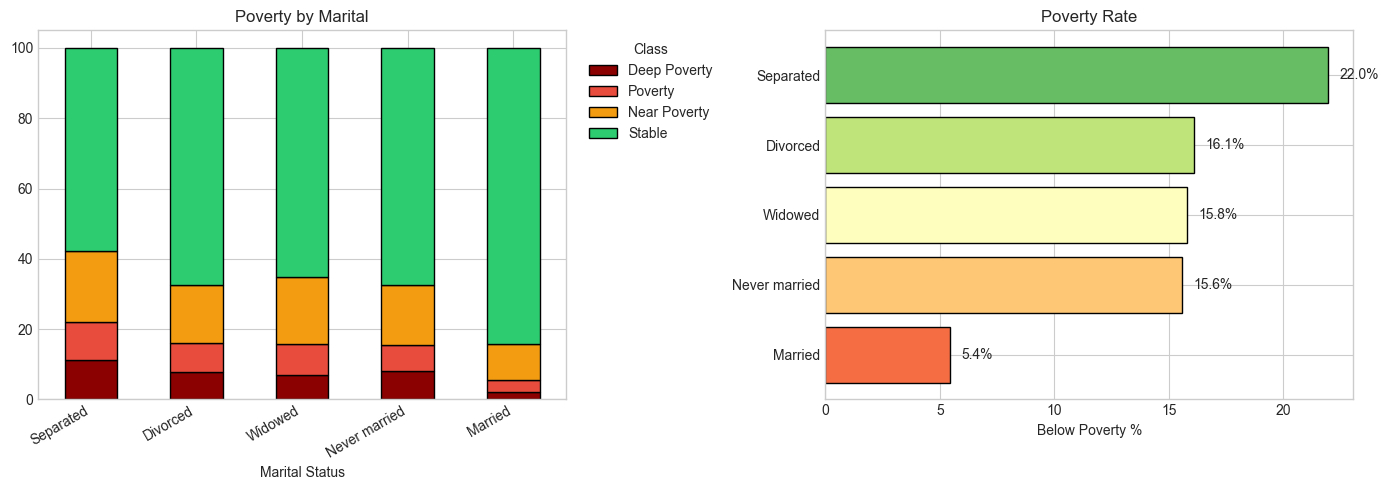

In [53]:
# VISUAL 13: Marital
df_analysis['marital'] = df_analysis['MAR'].map({1:'Married',2:'Widowed',3:'Divorced',4:'Separated',5:'Never married'})
mar_dist = df_analysis.dropna(subset=['marital']).groupby(['marital', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
mar_pct = mar_dist.div(mar_dist.sum(axis=1), axis=0)*100
vuln = mar_pct['Deep Poverty']+mar_pct['Poverty']
mar_pct = mar_pct.loc[vuln.sort_values(ascending=False).index]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
mar_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_xlabel('Marital Status'); axes[0].set_title('Poverty by Marital'); axes[0].legend(title='Class', bbox_to_anchor=(1.02,1))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=30, ha='right')
vuln_sorted = vuln.sort_values(ascending=True)
colors_grad = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(vuln_sorted)))
bars = axes[1].barh(range(len(vuln_sorted)), vuln_sorted.values, color=colors_grad, edgecolor='black')
axes[1].set_yticks(range(len(vuln_sorted))); axes[1].set_yticklabels(vuln_sorted.index)
axes[1].set_xlabel('Below Poverty %'); axes[1].set_title('Poverty Rate')
for b,r in zip(bars, vuln_sorted.values): axes[1].text(b.get_width()+0.5, b.get_y()+b.get_height()/2, f'{r:.1f}%', va='center')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_marital.png', dpi=150, bbox_inches='tight')
plt.show()

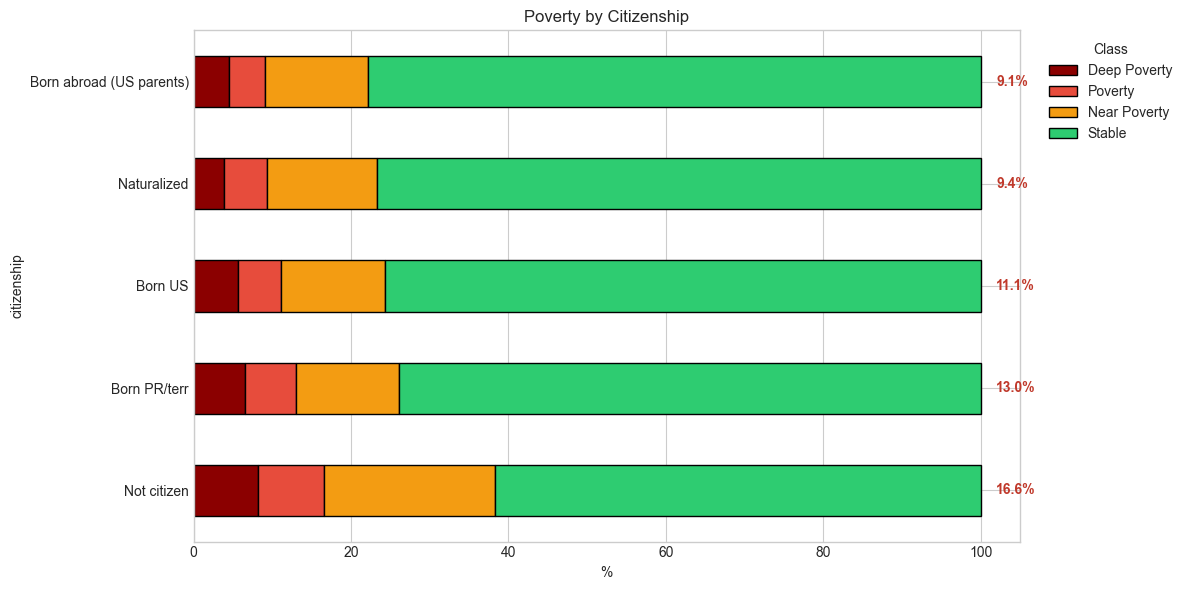

In [54]:
# VISUAL 14: Citizenship
df_analysis['citizenship'] = df_analysis['CIT'].map({1:'Born US',2:'Born PR/terr',3:'Born abroad (US parents)',4:'Naturalized',5:'Not citizen'})
cit_dist = df_analysis.dropna(subset=['citizenship']).groupby(['citizenship', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
cit_pct = cit_dist.div(cit_dist.sum(axis=1), axis=0)*100
vuln = cit_pct['Deep Poverty']+cit_pct['Poverty']
cit_pct = cit_pct.loc[vuln.sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(12, 6))
cit_pct.plot(kind='barh', stacked=True, ax=ax, color=CLASS_COLORS_LIST, edgecolor='black')
ax.set_xlabel('%'); ax.set_title('Poverty by Citizenship'); ax.legend(title='Class', bbox_to_anchor=(1.02,1))
for i, (idx, row) in enumerate(cit_pct.iterrows()):
    v = row['Deep Poverty']+row['Poverty']
    ax.text(102, i, f'{v:.1f}%', va='center', fontweight='bold', color='#c0392b')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_citizenship.png', dpi=150, bbox_inches='tight')
plt.show()

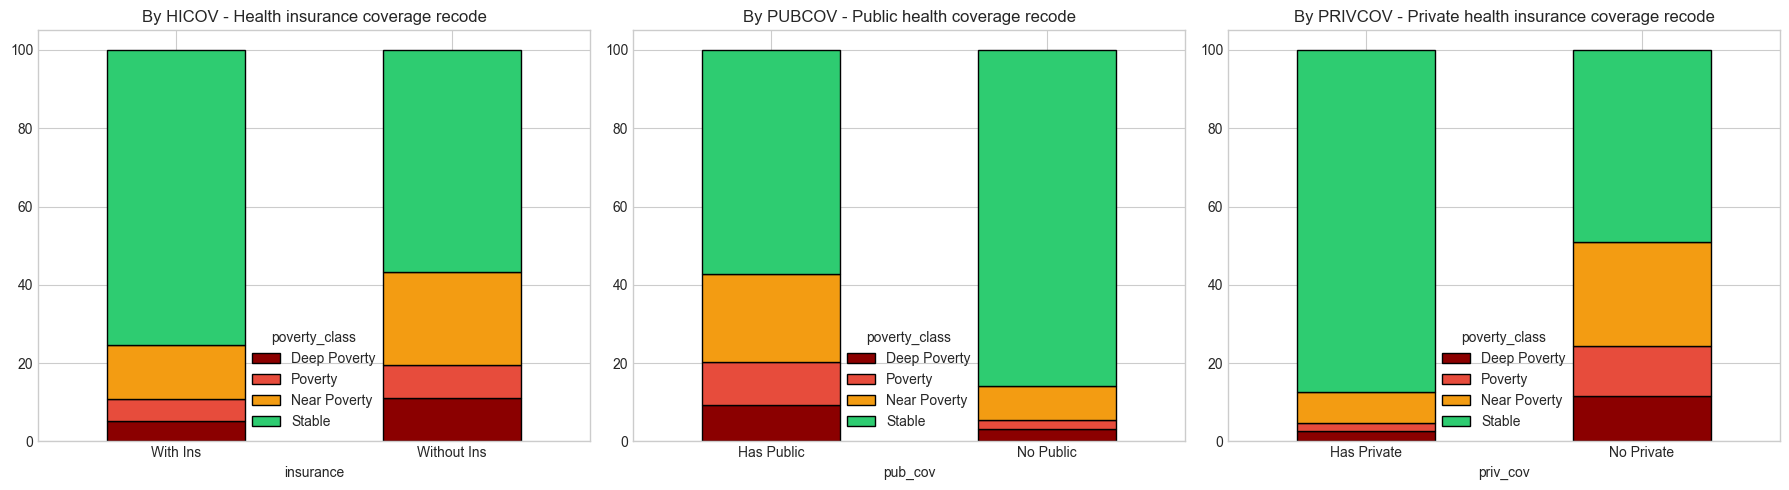

In [55]:
# VISUAL 15: Health Insurance (3 types)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df_analysis['insurance'] = df_analysis['HICOV'].map({1:'With Ins',2:'Without Ins'})
ins_dist = df_analysis.dropna(subset=['insurance']).groupby(['insurance', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
ins_pct = ins_dist.div(ins_dist.sum(axis=1), axis=0)*100
ins_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
axes[0].set_title('By HICOV - Health insurance coverage recode'); axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
if 'PUBCOV' in df_analysis.columns:
    df_analysis['pub_cov'] = df_analysis['PUBCOV'].map({1:'Has Public',2:'No Public'})
    pub_dist = df_analysis.dropna(subset=['pub_cov']).groupby(['pub_cov', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
    pub_pct = pub_dist.div(pub_dist.sum(axis=1), axis=0)*100
    pub_pct.plot(kind='bar', stacked=True, ax=axes[1], color=CLASS_COLORS_LIST, edgecolor='black')
    axes[1].set_title('By PUBCOV - Public health coverage recode'); axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
if 'PRIVCOV' in df_analysis.columns:
    df_analysis['priv_cov'] = df_analysis['PRIVCOV'].map({1:'Has Private',2:'No Private'})
    priv_dist = df_analysis.dropna(subset=['priv_cov']).groupby(['priv_cov', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
    priv_pct = priv_dist.div(priv_dist.sum(axis=1), axis=0)*100
    priv_pct.plot(kind='bar', stacked=True, ax=axes[2], color=CLASS_COLORS_LIST, edgecolor='black')
    axes[2].set_title('By PRIVCOV - Private health insurance coverage recode'); axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_health_insurance.png', dpi=150, bbox_inches='tight')
plt.show()

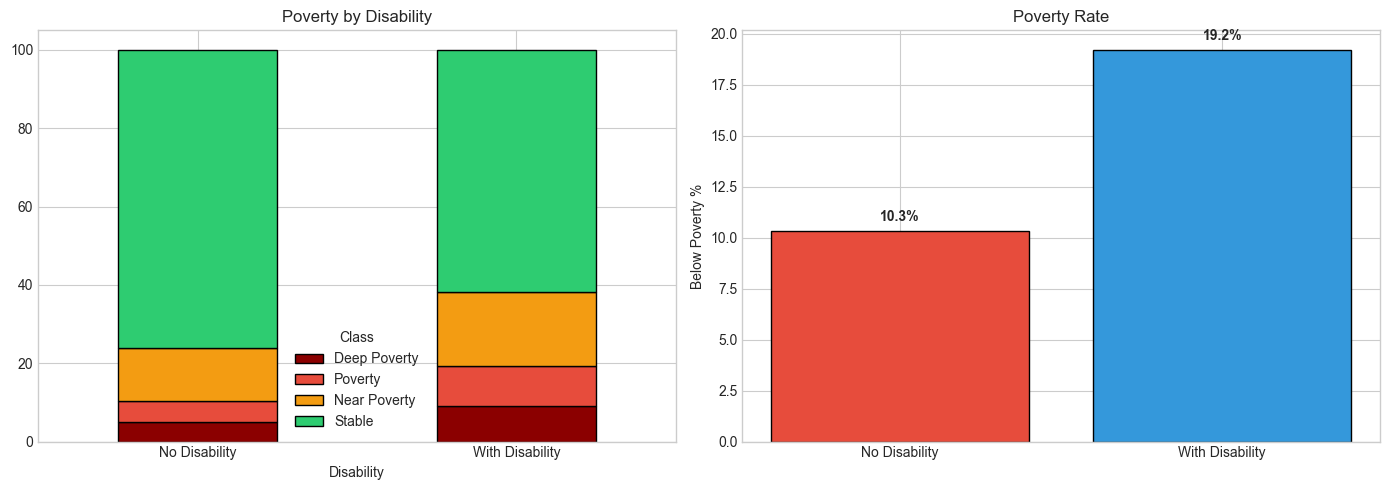

In [56]:
# VISUAL 16: Disability
if 'DIS' in df_analysis.columns:
    df_analysis['disability'] = df_analysis['DIS'].map({1:'With Disability',2:'No Disability'})
    dis_dist = df_analysis.dropna(subset=['disability']).groupby(['disability', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
    dis_pct = dis_dist.div(dis_dist.sum(axis=1), axis=0)*100
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    dis_pct.plot(kind='bar', stacked=True, ax=axes[0], color=CLASS_COLORS_LIST, edgecolor='black')
    axes[0].set_xlabel('Disability'); axes[0].set_title('Poverty by Disability'); axes[0].legend(title='Class')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    vuln = dis_pct['Deep Poverty']+dis_pct['Poverty']
    bars = axes[1].bar(vuln.index, vuln.values, color=['#e74c3c','#3498db'], edgecolor='black')
    axes[1].set_ylabel('Below Poverty %'); axes[1].set_title('Poverty Rate')
    for b,r in zip(bars, vuln.values): axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f'{r:.1f}%', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_disability.png', dpi=150, bbox_inches='tight')
    plt.show()

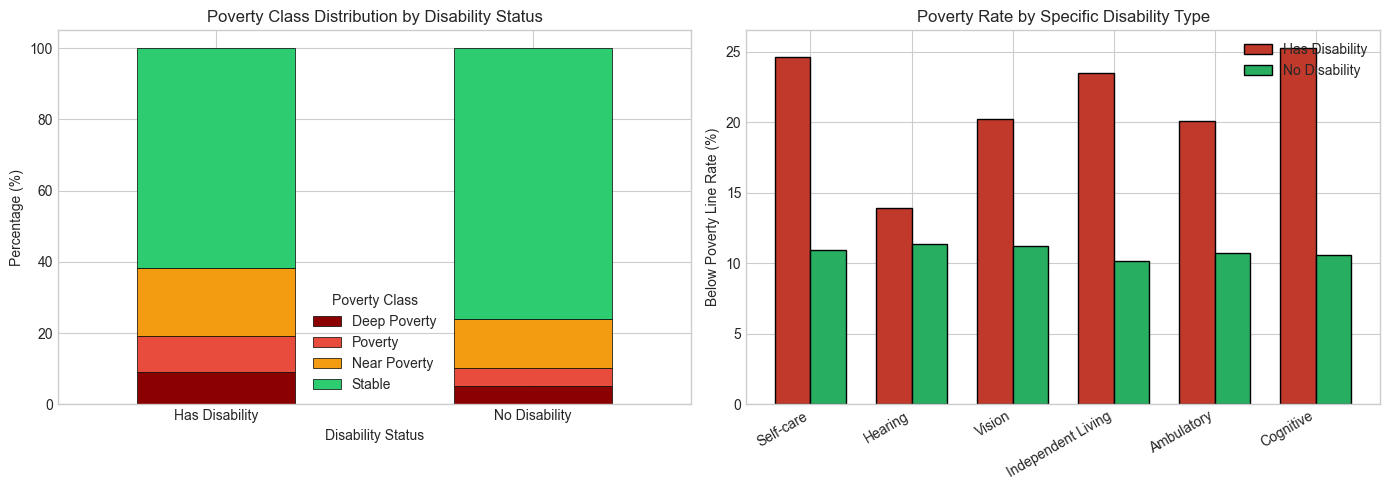


Poverty Class Distribution by Disability Status (%):
poverty_class   Deep Poverty  Poverty  Near Poverty  Stable
disability                                                 
Has Disability           9.1     10.1          19.1    61.7
No Disability            5.1      5.2          13.6    76.1


Below Poverty Line Rate by Disability Type:
   Disability Type  Has Disability  No Disability
         Self-care       24.587533      10.914709
           Hearing       13.914676      11.341301
            Vision       20.199218      11.231137
Independent Living       23.465071      10.139585
        Ambulatory       20.072985      10.714155
         Cognitive       25.241423      10.589947


In [57]:
# Poverty Class Distribution by Disability Status
dis_mapping = {1: 'Has Disability', 2: 'No Disability'}
df_analysis['disability'] = df_analysis['DIS'].map(dis_mapping)

class_order = ['Deep Poverty', 'Poverty', 'Near Poverty', 'Stable']
class_colors = {'Deep Poverty': '#8B0000', 'Poverty': '#e74c3c', 'Near Poverty': '#f39c12', 'Stable': '#2ecc71'}

# Calculate poverty class distribution by disability
dis_dist = df_analysis.dropna(subset=['disability']).groupby(['disability', 'poverty_class']).size().unstack(fill_value=0)
dis_dist = dis_dist[class_order]
dis_dist_pct = dis_dist.div(dis_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar by disability status
dis_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                  color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Disability Status')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Disability Status')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Individual disability types - vulnerable rate comparison
disability_cols = ['DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DREM']
disability_labels = ['Self-care', 'Hearing', 'Vision', 'Independent Living', 'Ambulatory', 'Cognitive']

disability_vuln_rates = []
for col, label in zip(disability_cols, disability_labels):
    has_dis_data = df_analysis[df_analysis[col] == 1]
    no_dis_data = df_analysis[df_analysis[col] == 2]
    
    has_dis_vuln = has_dis_data['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
    no_dis_vuln = no_dis_data['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
    
    disability_vuln_rates.append({
        'Disability Type': label, 
        'Has Disability': has_dis_vuln, 
        'No Disability': no_dis_vuln
    })

dis_df = pd.DataFrame(disability_vuln_rates)

x = np.arange(len(dis_df))
width = 0.35
bars1 = axes[1].bar(x - width/2, dis_df['Has Disability'], width, label='Has Disability', color='#c0392b', edgecolor='black')
bars2 = axes[1].bar(x + width/2, dis_df['No Disability'], width, label='No Disability', color='#27ae60', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dis_df['Disability Type'], rotation=30, ha='right')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Specific Disability Type')
axes[1].legend()

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_disability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Class Distribution by Disability Status (%):")
print(dis_dist_pct.round(1).to_string())
print("\n\nBelow Poverty Line Rate by Disability Type:")
print(dis_df.to_string(index=False))

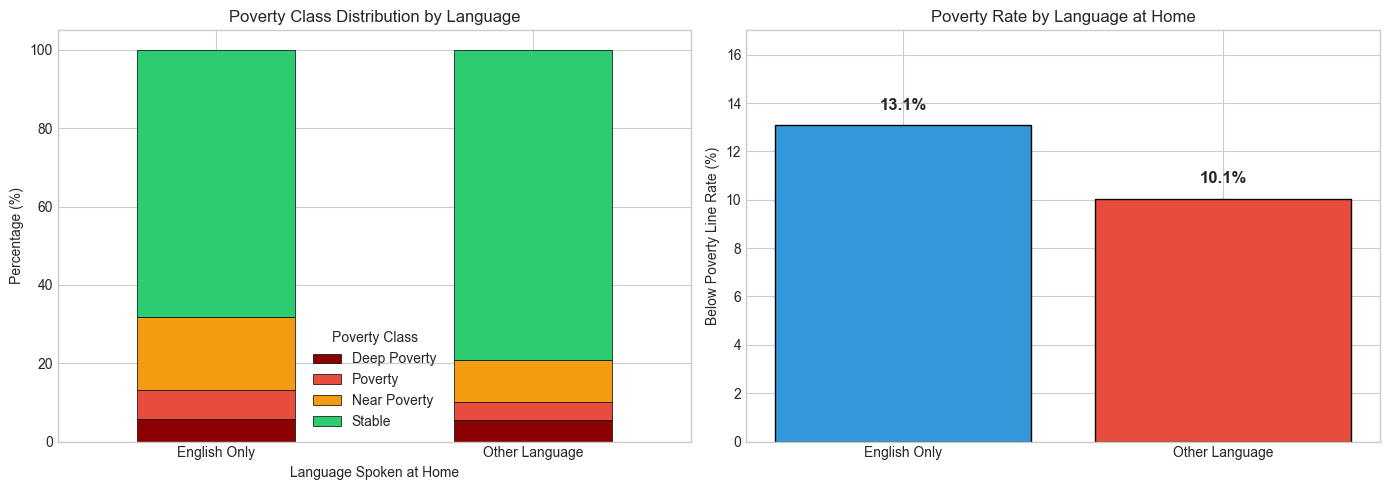


Poverty Rate by Language:
  English Only: 13.1%
  Other Language: 10.1%


In [58]:
# Poverty by Language Spoken at Home (LANX)
lanx_mapping = {1: 'English Only', 2: 'Other Language'}
df_analysis['language'] = df_analysis['LANX'].map(lanx_mapping)

lang_dist = df_analysis.dropna(subset=['language']).groupby(['language', 'poverty_class']).size().unstack(fill_value=0)
lang_dist = lang_dist[class_order]
lang_dist_pct = lang_dist.div(lang_dist.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
lang_dist_pct.plot(kind='bar', stacked=True, ax=axes[0],
                   color=[class_colors[c] for c in class_order], edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Language Spoken at Home')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Poverty Class Distribution by Language')
axes[0].legend(title='Poverty Class')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Comparison bar chart
vulnerable_lang = lang_dist_pct['Deep Poverty'] + lang_dist_pct['Poverty']
colors_bar = ['#3498db', '#e74c3c']
bars = axes[1].bar(vulnerable_lang.index, vulnerable_lang.values, color=colors_bar, edgecolor='black')
axes[1].set_ylabel('Below Poverty Line Rate (%)')
axes[1].set_title('Poverty Rate by Language at Home')
axes[1].set_ylim(0, max(vulnerable_lang.values) * 1.3)

for bar, rate in zip(bars, vulnerable_lang.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_by_language.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPoverty Rate by Language:")
for lang, rate in vulnerable_lang.items():
    print(f"  {lang}: {rate:.1f}%")

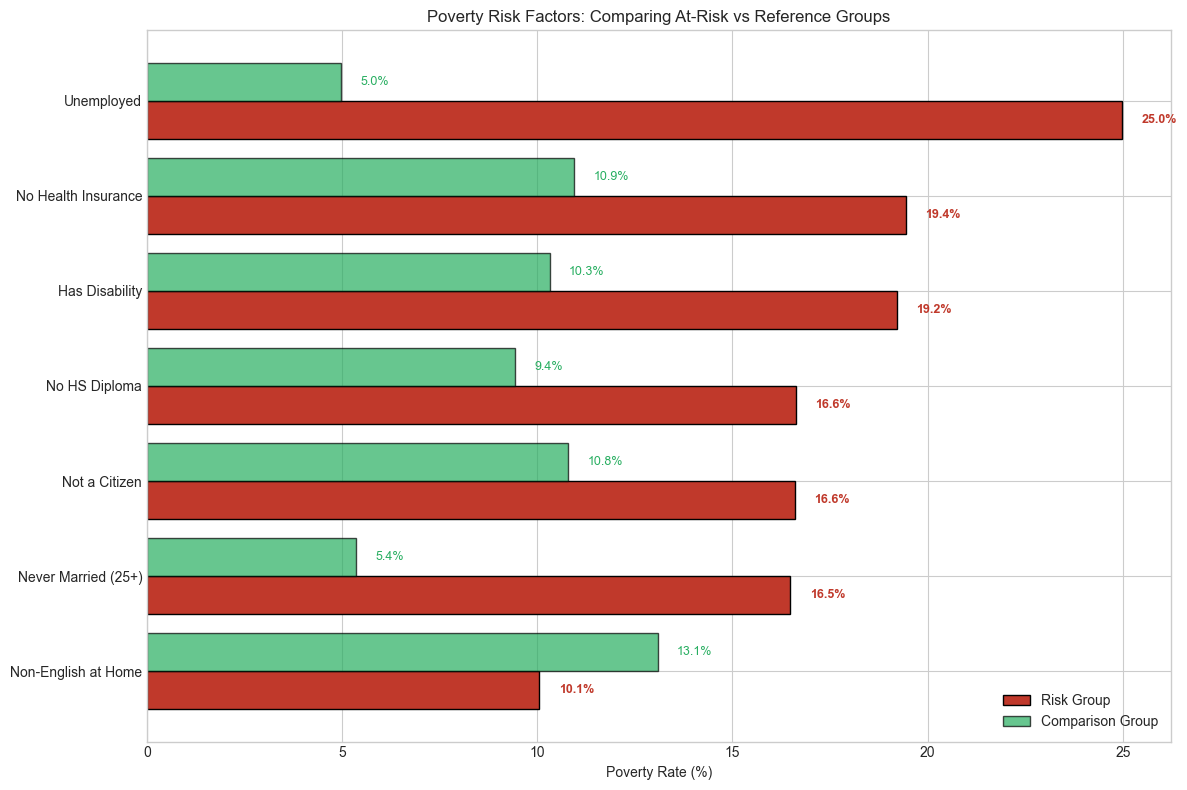


=== Poverty Risk Factor Summary ===
Factor                       At-Risk   Baseline   Difference
------------------------------------------------------------
Unemployed                     25.0%       5.0%       +20.0%
Never Married (25+)            16.5%       5.4%       +11.1%
Has Disability                 19.2%      10.3%        +8.9%
No Health Insurance            19.4%      10.9%        +8.5%
No HS Diploma                  16.6%       9.4%        +7.2%
Not a Citizen                  16.6%      10.8%        +5.8%
Non-English at Home            10.1%      13.1%        -3.0%


In [59]:
# Summary: Risk Factor Comparison Chart
# Calculate poverty rates for key binary/categorical risk factors

risk_factors = []

# Disability
has_dis = df_analysis[df_analysis['DIS'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
no_dis = df_analysis[df_analysis['DIS'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Has Disability', 'Rate': has_dis, 'Baseline': no_dis})

# No Health Insurance
no_ins = df_analysis[df_analysis['HICOV'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
has_ins = df_analysis[df_analysis['HICOV'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'No Health Insurance', 'Rate': no_ins, 'Baseline': has_ins})

# Unemployed
unemployed = df_analysis[df_analysis['ESR'] == 3]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
employed = df_analysis[df_analysis['ESR'].isin([1, 2])]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Unemployed', 'Rate': unemployed, 'Baseline': employed})

# No HS Diploma
no_hs = df_analysis[df_analysis['education'] == 'No HS']['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
has_hs = df_analysis[df_analysis['education'] != 'No HS']['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'No HS Diploma', 'Rate': no_hs, 'Baseline': has_hs})

# Not a Citizen
not_cit = df_analysis[df_analysis['CIT'] == 5]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
is_cit = df_analysis[df_analysis['CIT'] != 5]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Not a Citizen', 'Rate': not_cit, 'Baseline': is_cit})

# Other Language at Home
other_lang = df_analysis[df_analysis['LANX'] == 2]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
english = df_analysis[df_analysis['LANX'] == 1]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Non-English at Home', 'Rate': other_lang, 'Baseline': english})

# Never Married (adults 25+)
never_mar = df_analysis[(df_analysis['MAR'] == 5) & (df_analysis['AGEP'] >= 25)]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
married = df_analysis[(df_analysis['MAR'] == 1) & (df_analysis['AGEP'] >= 25)]['poverty_class'].isin(['Deep Poverty', 'Poverty']).mean() * 100
risk_factors.append({'Factor': 'Never Married (25+)', 'Rate': never_mar, 'Baseline': married})

rf_df = pd.DataFrame(risk_factors)
rf_df['Difference'] = rf_df['Rate'] - rf_df['Baseline']
rf_df = rf_df.sort_values('Rate', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart
y_pos = range(len(rf_df))
bars = ax.barh(y_pos, rf_df['Rate'], color='#c0392b', edgecolor='black', label='Risk Group', height=0.4)
bars2 = ax.barh([y + 0.4 for y in y_pos], rf_df['Baseline'], color='#27ae60', edgecolor='black', 
                label='Comparison Group', height=0.4, alpha=0.7)

ax.set_yticks([y + 0.2 for y in y_pos])
ax.set_yticklabels(rf_df['Factor'])
ax.set_xlabel('Poverty Rate (%)')
ax.set_title('Poverty Risk Factors: Comparing At-Risk vs Reference Groups', fontsize=12)
ax.legend(loc='lower right')

# Add rate labels
for i, (idx, row) in enumerate(rf_df.iterrows()):
    ax.text(row['Rate'] + 0.5, i, f'{row["Rate"]:.1f}%', va='center', fontsize=9, color='#c0392b', fontweight='bold')
    ax.text(row['Baseline'] + 0.5, i + 0.4, f'{row["Baseline"]:.1f}%', va='center', fontsize=9, color='#27ae60')

plt.tight_layout()
plt.savefig('EDA_data/poverty_risk_factors_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Poverty Risk Factor Summary ===")
print(f"{'Factor':<25} {'At-Risk':>10} {'Baseline':>10} {'Difference':>12}")
print("-" * 60)
for _, row in rf_df.sort_values('Difference', ascending=False).iterrows():
    print(f"{row['Factor']:<25} {row['Rate']:>9.1f}% {row['Baseline']:>9.1f}% {row['Difference']:>+11.1f}%")

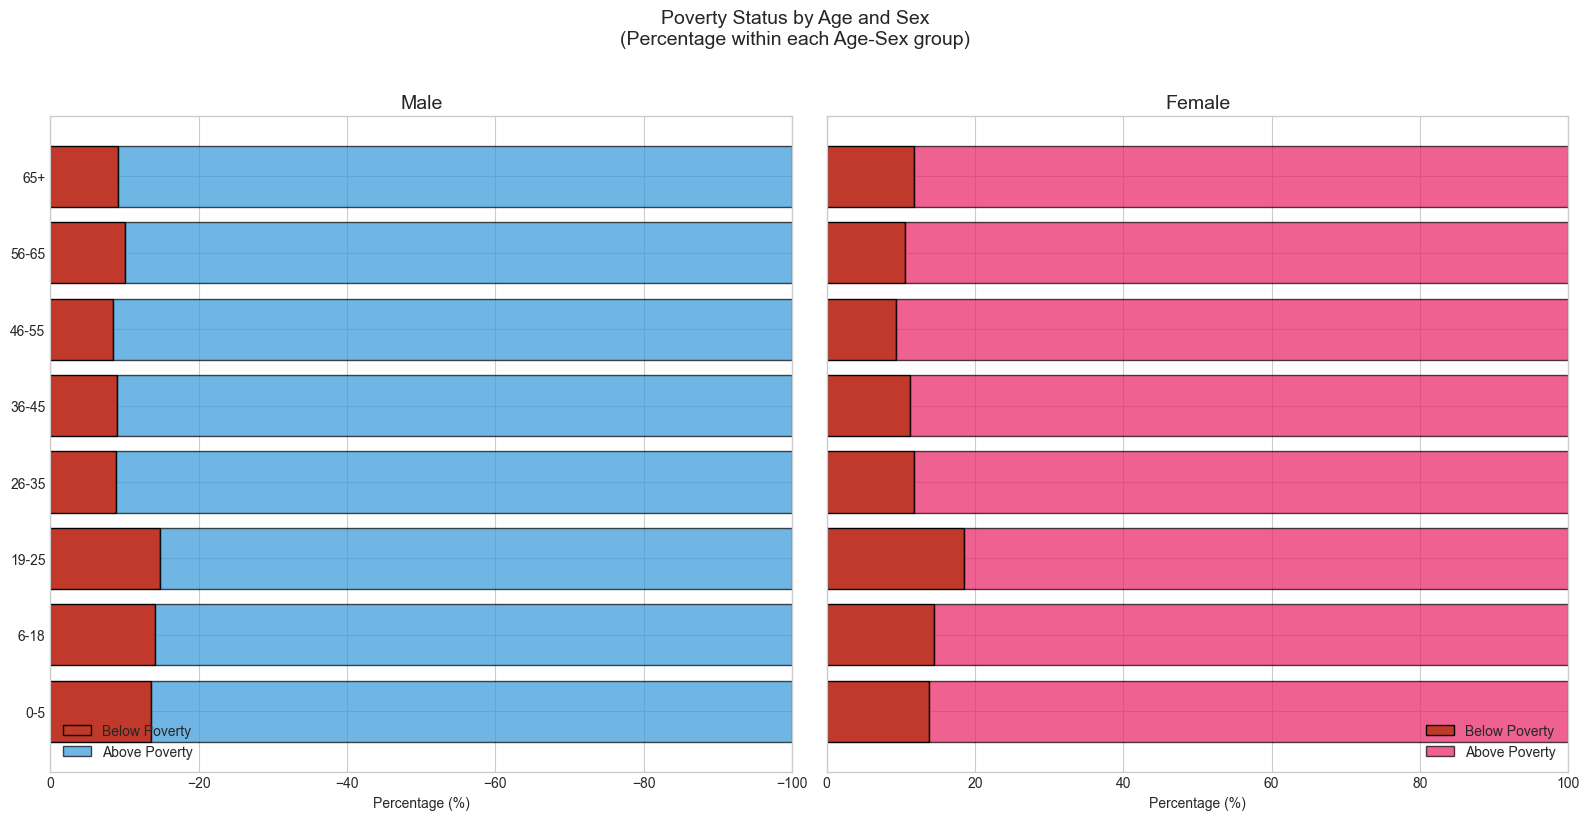


Poverty Rate by Age and Sex:

Male:
age_group
0-5      13.6
6-18     14.1
19-25    14.7
26-35     8.8
36-45     8.9
46-55     8.4
56-65    10.1
65+       9.1

Female:
age_group
0-5      13.7
6-18     14.4
19-25    18.5
26-35    11.8
36-45    11.2
46-55     9.3
56-65    10.6
65+      11.8


In [60]:
# Population Pyramid: Age Distribution by Sex and Poverty Status
df_pyramid = df_analysis.dropna(subset=['age_group', 'sex', 'poverty_class']).copy()

# Create vulnerable indicator
df_pyramid['vulnerable'] = df_pyramid['poverty_class'].isin(['Deep Poverty', 'Poverty'])

age_order = ['0-5', '6-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Calculate counts by age, sex, and vulnerability
pyramid_data = df_pyramid.groupby(['age_group', 'sex', 'vulnerable']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left side: Male
male_data = df_pyramid[df_pyramid['sex'] == 'Male'].groupby('age_group')['vulnerable'].value_counts(normalize=True).unstack(fill_value=0) * 100
male_data = male_data.reindex(age_order)

# Right side: Female
female_data = df_pyramid[df_pyramid['sex'] == 'Female'].groupby('age_group')['vulnerable'].value_counts(normalize=True).unstack(fill_value=0) * 100
female_data = female_data.reindex(age_order)

# Plot Male (left, reversed)
y_pos = range(len(age_order))
axes[0].barh(y_pos, -male_data[True], color='#c0392b', label='Below Poverty', edgecolor='black')
axes[0].barh(y_pos, -male_data[False], left=-male_data[True], color='#3498db', label='Above Poverty', edgecolor='black', alpha=0.7)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(age_order)
axes[0].set_xlabel('Percentage (%)')
axes[0].set_title('Male', fontsize=14)
axes[0].set_xlim(-100, 0)
axes[0].invert_xaxis()
axes[0].legend(loc='lower left')

# Plot Female (right)
axes[1].barh(y_pos, female_data[True], color='#c0392b', label='Below Poverty', edgecolor='black')
axes[1].barh(y_pos, female_data[False], left=female_data[True], color='#e91e63', label='Above Poverty', edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([])
axes[1].set_xlabel('Percentage (%)')
axes[1].set_title('Female', fontsize=14)
axes[1].set_xlim(0, 100)
axes[1].legend(loc='lower right')

fig.suptitle('Poverty Status by Age and Sex\n(Percentage within each Age-Sex group)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('EDA_data/poverty_pyramid_age_sex.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPoverty Rate by Age and Sex:")
print("\nMale:")
print((male_data[True]).round(1).to_string())
print("\nFemale:")
print((female_data[True]).round(1).to_string())

<a id='intersectional'></a>
## 9. Intersectional Analysis

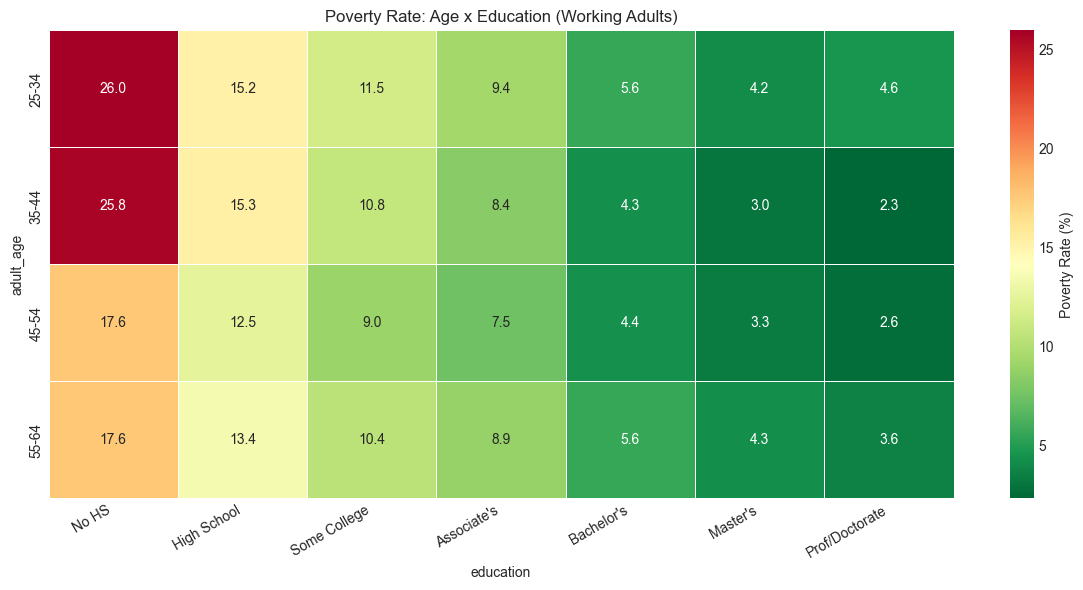

In [61]:
# VISUAL 17: Age x Education Heatmap
df_adults = df_analysis[(df_analysis['AGEP']>=25)&(df_analysis['AGEP']<=64)].copy()
df_adults['adult_age'] = pd.cut(df_adults['AGEP'], bins=[24,34,44,54,64], labels=['25-34','35-44','45-54','55-64'])
intersect = df_adults.groupby(['adult_age', 'education']).apply(lambda x: (x['poverty_class'].isin(['Deep Poverty','Poverty'])).mean()*100).unstack()
edu_order = ['No HS', 'High School', 'Some College', "Associate's", "Bachelor's", "Master's", 'Prof/Doctorate']
intersect = intersect[[c for c in edu_order if c in intersect.columns]]
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(intersect, annot=True, fmt='.1f', cmap='RdYlGn_r', linewidths=0.5, ax=ax, cbar_kws={'label': 'Poverty Rate (%)'})
ax.set_title('Poverty Rate: Age x Education (Working Adults)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/poverty_heatmap_age_education.png', dpi=150, bbox_inches='tight')
plt.show()

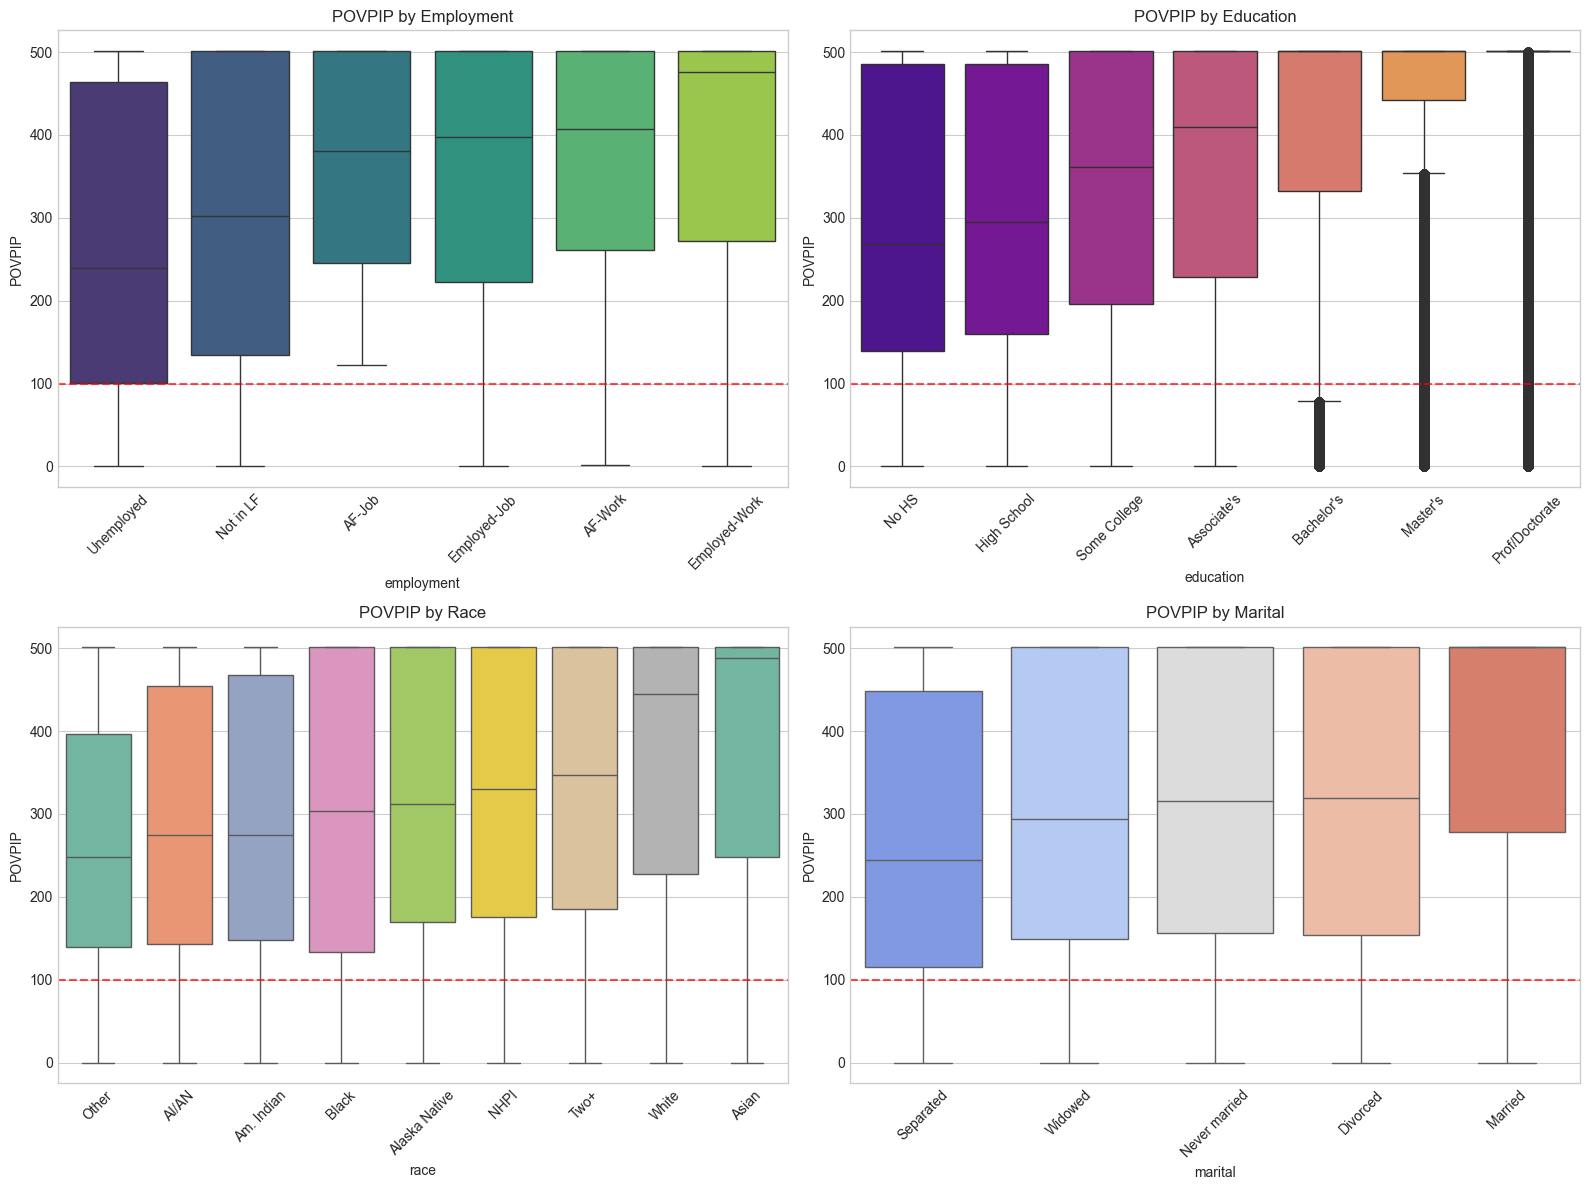

In [62]:
# VISUAL 18: Box Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
df_box = df_analysis.dropna(subset=['employment', 'POVPIP'])
order = df_box.groupby('employment')['POVPIP'].median().sort_values().index
sns.boxplot(data=df_box, x='employment', y='POVPIP', order=order, ax=axes[0,0], palette='viridis')
axes[0,0].set_title('POVPIP by Employment'); axes[0,0].tick_params(axis='x', rotation=45); axes[0,0].axhline(y=100, color='red', linestyle='--', alpha=0.7)
df_box = df_analysis.dropna(subset=['education', 'POVPIP'])
edu_order_box = [e for e in edu_order if e in df_box['education'].values]
sns.boxplot(data=df_box, x='education', y='POVPIP', order=edu_order_box, ax=axes[0,1], palette='plasma')
axes[0,1].set_title('POVPIP by Education'); axes[0,1].tick_params(axis='x', rotation=45); axes[0,1].axhline(y=100, color='red', linestyle='--', alpha=0.7)
df_box = df_analysis.dropna(subset=['race', 'POVPIP'])
race_order = df_box.groupby('race')['POVPIP'].median().sort_values().index
sns.boxplot(data=df_box, x='race', y='POVPIP', order=race_order, ax=axes[1,0], palette='Set2')
axes[1,0].set_title('POVPIP by Race'); axes[1,0].tick_params(axis='x', rotation=45); axes[1,0].axhline(y=100, color='red', linestyle='--', alpha=0.7)
df_box = df_analysis.dropna(subset=['marital', 'POVPIP'])
mar_order = df_box.groupby('marital')['POVPIP'].median().sort_values().index
sns.boxplot(data=df_box, x='marital', y='POVPIP', order=mar_order, ax=axes[1,1], palette='coolwarm')
axes[1,1].set_title('POVPIP by Marital'); axes[1,1].tick_params(axis='x', rotation=45); axes[1,1].axhline(y=100, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/povpip_boxplots_demographics.png', dpi=150, bbox_inches='tight')
plt.show()

<a id='regional'></a>
## 10. Regional Analysis

In [63]:
def map_puma_to_region(puma):
    if pd.isna(puma): return 'Unknown'
    p = int(puma)
    if p<1500: return 'Northern CA/Sierras'
    if 1500<=p<3000: return 'Bay Area'
    if 3000<=p<5000: return 'Central Valley'
    if 5000<=p<7000: return 'Central Coast'
    if 7000<=p<9000: return 'Los Angeles'
    if 9000<=p<10000: return 'Inland Empire'
    if p>=10000: return 'San Diego/Border'
    return 'Unknown'
if 'PUMA' in df_analysis.columns:
    df_analysis['CA_Region'] = df_analysis['PUMA'].apply(map_puma_to_region)
    region_risk = df_analysis.groupby('CA_Region')['poverty_risk_score'].mean().sort_values(ascending=False)
    print('Mean Poverty Risk by Region:')
    print(region_risk.round(3).to_string())

Mean Poverty Risk by Region:
CA_Region
Bay Area               0.623
Central Valley         0.491
San Diego/Border       0.472
Inland Empire          0.393
Central Coast          0.391
Los Angeles            0.373
Northern CA/Sierras    0.340


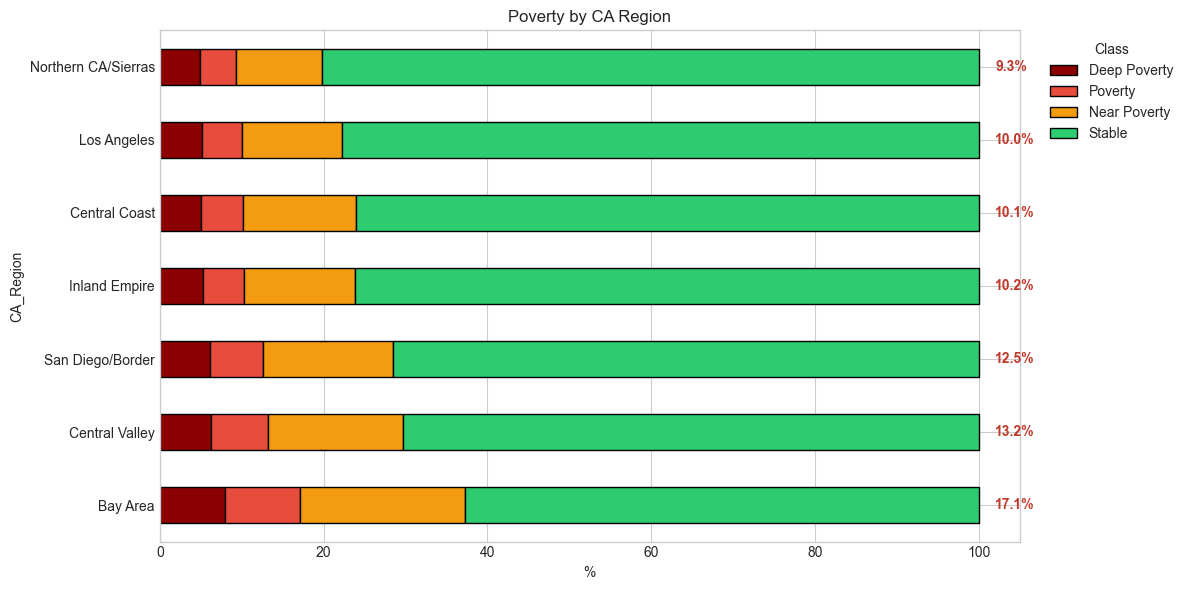

In [64]:
# VISUAL 19: Regional Poverty
if 'CA_Region' in df_analysis.columns:
    region_dist = df_analysis.dropna(subset=['CA_Region']).groupby(['CA_Region', 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
    region_pct = region_dist.div(region_dist.sum(axis=1), axis=0)*100
    vuln = region_pct['Deep Poverty']+region_pct['Poverty']
    region_pct = region_pct.loc[vuln.sort_values(ascending=False).index]
    fig, ax = plt.subplots(figsize=(12, 6))
    region_pct.plot(kind='barh', stacked=True, ax=ax, color=CLASS_COLORS_LIST, edgecolor='black')
    ax.set_xlabel('%'); ax.set_title('Poverty by CA Region'); ax.legend(title='Class', bbox_to_anchor=(1.02,1))
    for i, (idx, row) in enumerate(region_pct.iterrows()):
        v = row['Deep Poverty']+row['Poverty']
        ax.text(102, i, f'{v:.1f}%', va='center', fontweight='bold', color='#c0392b')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_region.png', dpi=150, bbox_inches='tight')
    plt.show()

TypeError: 'generator' object is not subscriptable

<Figure size 1200x800 with 0 Axes>

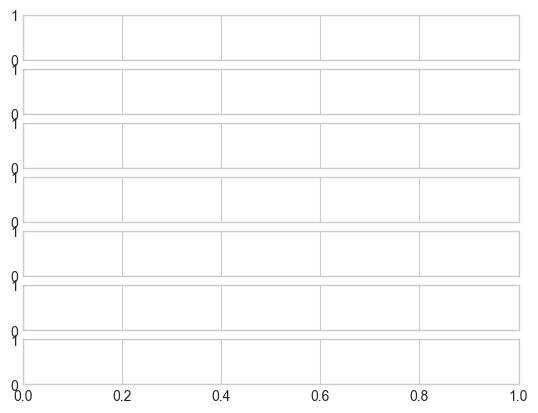

In [65]:
# VISUAL 20: Regional Joyplot
import joypy

if 'CA_Region' in df_analysis.columns:
    region_data = df_analysis[['CA_Region', 'POVPIP']].dropna()
    region_data = region_data[region_data['CA_Region']!='Unknown']
    plt.figure(figsize=(12, 8))
    fig, axes = joypy.joyplot(region_data, by='CA_Region', column='POVPIP', colormap=plt.cm.RdYlGn_r, fade=True, title='Poverty Risk Distribution by CA Region')
    plt.xlabel('Poverty-Income Ratio')
    plt.savefig(f'{OUTPUT_DIR}/regional_poverty_joyplot.png', dpi=150, bbox_inches='tight')
    plt.show()

<a id='temporal'></a>
## 11. Temporal Analysis

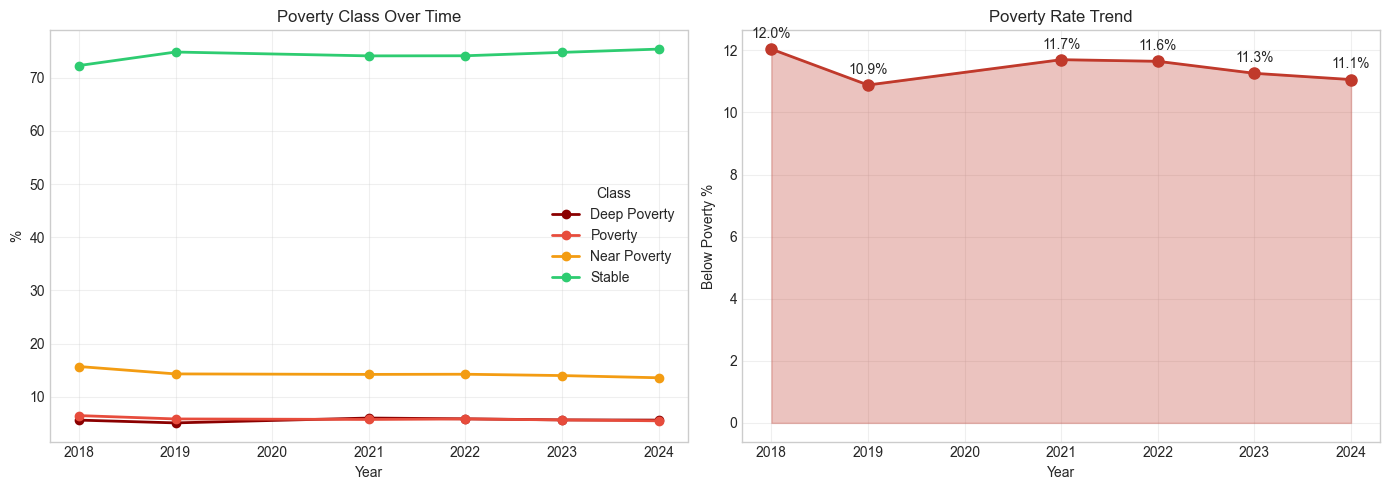

In [66]:
# VISUAL 21: Trends Over Time
year_col = 'year' if 'year' in df.columns else 'SURVEY_YEAR' if 'SURVEY_YEAR' in df.columns else None
if year_col and df[year_col].nunique() > 1:
    year_dist = df.dropna(subset=[year_col, 'poverty_class']).groupby([year_col, 'poverty_class']).size().unstack(fill_value=0)[CLASS_ORDER]
    year_pct = year_dist.div(year_dist.sum(axis=1), axis=0)*100
    vuln_by_year = year_pct['Deep Poverty']+year_pct['Poverty']
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for cls in CLASS_ORDER:
        axes[0].plot(year_pct.index, year_pct[cls], marker='o', lw=2, color=CLASS_COLORS[cls], label=cls)
    axes[0].set_xlabel('Year'); axes[0].set_ylabel('%'); axes[0].set_title('Poverty Class Over Time'); axes[0].legend(title='Class'); axes[0].grid(True, alpha=0.3)
    axes[1].plot(vuln_by_year.index, vuln_by_year.values, marker='o', lw=2, ms=8, color='#c0392b')
    axes[1].fill_between(vuln_by_year.index, vuln_by_year.values, alpha=0.3, color='#c0392b')
    axes[1].set_xlabel('Year'); axes[1].set_ylabel('Below Poverty %'); axes[1].set_title('Poverty Rate Trend'); axes[1].grid(True, alpha=0.3)
    for yr,r in zip(vuln_by_year.index, vuln_by_year.values): axes[1].annotate(f'{r:.1f}%', (yr,r), textcoords='offset points', xytext=(0,8), ha='center')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/poverty_class_by_year.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Multi-year temporal analysis skipped')

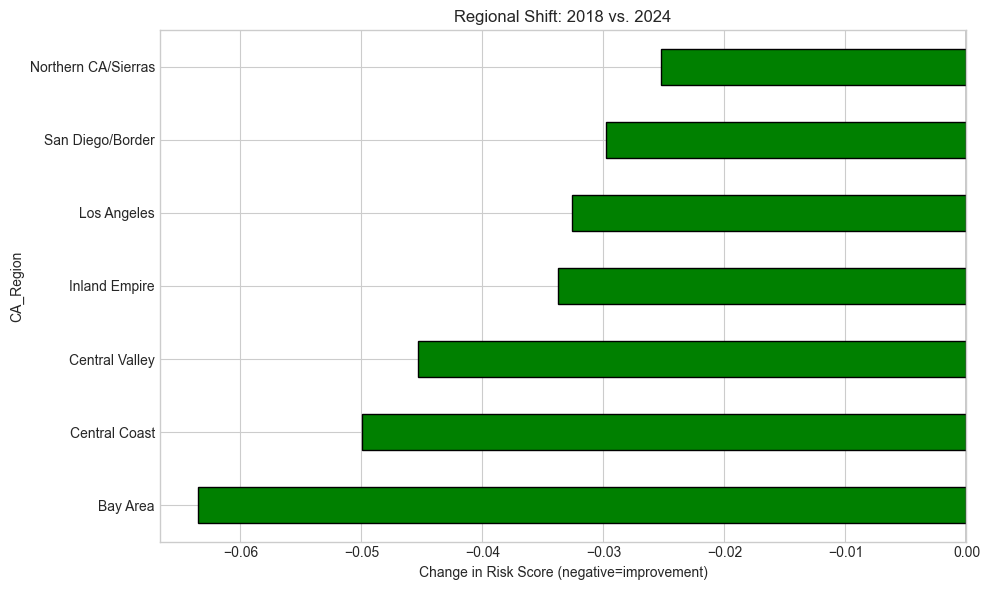

In [67]:
# VISUAL 22: Regional Shift
if year_col and df[year_col].nunique() > 1 and 'CA_Region' in df_analysis.columns:
    years = sorted(df[year_col].dropna().unique())
    start_yr, end_yr = years[0], years[-1]
    region_year_risk = df_analysis.groupby(['CA_Region', year_col])['poverty_risk_score'].mean().unstack()
    if start_yr in region_year_risk.columns and end_yr in region_year_risk.columns:
        delta = (region_year_risk[end_yr] - region_year_risk[start_yr]).sort_values().dropna()
        plt.figure(figsize=(10, 6))
        colors = ['green' if x<0 else 'red' for x in delta]
        delta.plot(kind='barh', color=colors, edgecolor='black')
        plt.title(f'Regional Shift: {int(start_yr)} vs. {int(end_yr)}')
        plt.xlabel('Change in Risk Score (negative=improvement)')
        plt.axvline(0, color='black', lw=1)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/regional_shift_poverty.png', dpi=150, bbox_inches='tight')
        plt.show()

<a id='drift'></a>
## 12. PSI Drift Analysis

Years: [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


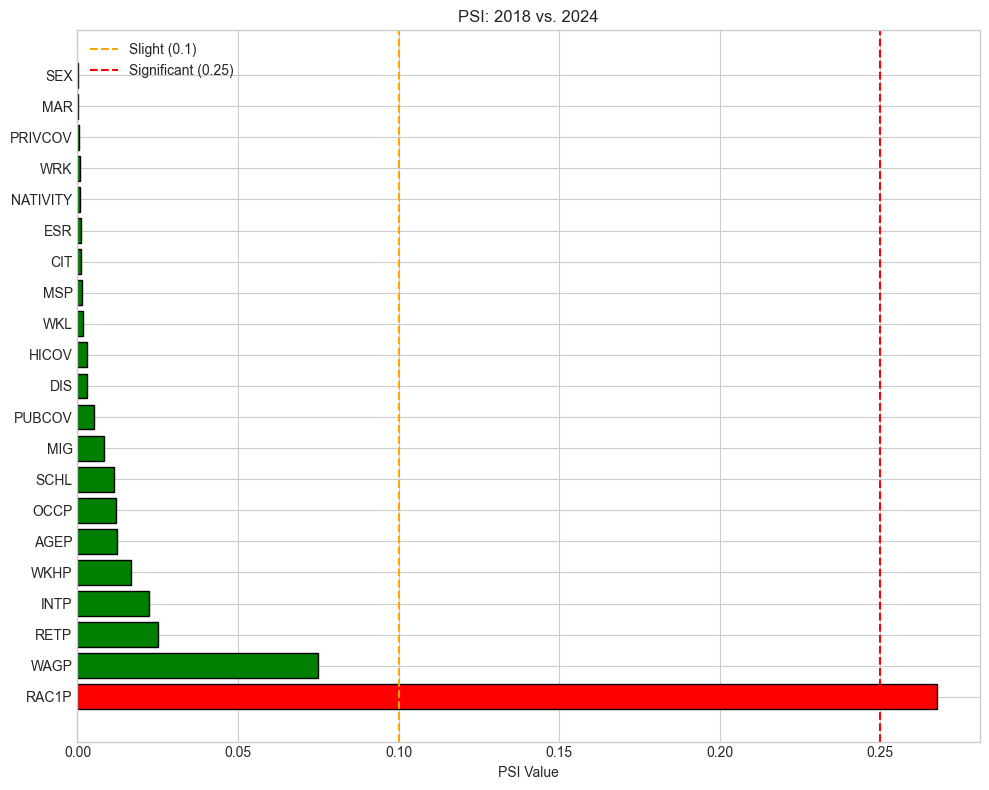

 Feature      PSI
   RAC1P 0.267710
    WAGP 0.074894
    RETP 0.025212
    INTP 0.022402
    WKHP 0.016765
    AGEP 0.012410
    OCCP 0.011917
    SCHL 0.011276
     MIG 0.008322
  PUBCOV 0.005066
     DIS 0.003035
   HICOV 0.002860
     WKL 0.001697
     MSP 0.001485
     CIT 0.001236
     ESR 0.001039
NATIVITY 0.000726
     WRK 0.000646
 PRIVCOV 0.000543
     MAR 0.000246
     SEX 0.000010


In [68]:
# VISUAL 23: PSI Analysis
def calculate_psi(expected, actual, bins=10):
    exp, act = expected.dropna(), actual.dropna()
    if len(exp)==0 or len(act)==0: return np.nan
    if exp.dtype=='object' or exp.nunique()<bins:
        exp_per = exp.value_counts(normalize=True).replace(0,0.0001)
        act_per = act.value_counts(normalize=True).reindex(exp_per.index, fill_value=0.0001)
    else:
        counts_exp, bin_edges = np.histogram(exp, bins=bins, density=True)
        counts_act, _ = np.histogram(act, bins=bin_edges, density=True)
        exp_per = counts_exp/(counts_exp.sum()+1e-10)+0.0001
        act_per = counts_act/(counts_act.sum()+1e-10)+0.0001
    return np.sum((act_per-exp_per)*np.log(act_per/exp_per))

if year_col and df[year_col].nunique()>1:
    years_avail = sorted(df[year_col].dropna().unique())
    print(f'Years: {years_avail}')
    feats = ['AGEP','SCHL','ESR','HICOV','SEX','WKHP','CIT','MAR','MIG','MSP','NATIVITY','OCCP','WKL','WRK','DIS','INTP','RETP','WAGP','PRIVCOV','PUBCOV','RAC1P']
    feats = [f for f in feats if f in df.columns]
    base_yr, target_yr = years_avail[0], years_avail[-1]
    base_df, target_df = df[df[year_col]==base_yr], df[df[year_col]==target_yr]
    psi_results = [{'Feature':f, 'PSI':calculate_psi(base_df[f],target_df[f])} for f in feats if not np.isnan(calculate_psi(base_df[f],target_df[f]))]
    if psi_results:
        psi_df = pd.DataFrame(psi_results).sort_values('PSI', ascending=False)
        plt.figure(figsize=(10, 8))
        colors = ['red' if x>0.25 else 'orange' if x>0.1 else 'green' for x in psi_df['PSI']]
        plt.barh(psi_df['Feature'], psi_df['PSI'], color=colors, edgecolor='black')
        plt.axvline(x=0.1, color='orange', linestyle='--', label='Slight (0.1)')
        plt.axvline(x=0.25, color='red', linestyle='--', label='Significant (0.25)')
        plt.title(f'PSI: {int(base_yr)} vs. {int(target_yr)}')
        plt.xlabel('PSI Value')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/feature_stability_psi.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(psi_df.to_string(index=False))
else:
    print('PSI requires multi-year data')

<a id='features'></a>
## 13. Feature Selection

In [69]:
print('=== Class Imbalance ===')
print(df['poverty_class'].value_counts())

=== Class Imbalance ===
poverty_class
Stable          1660529
Near Poverty     320025
Poverty          129920
Deep Poverty     125723
Name: count, dtype: int64


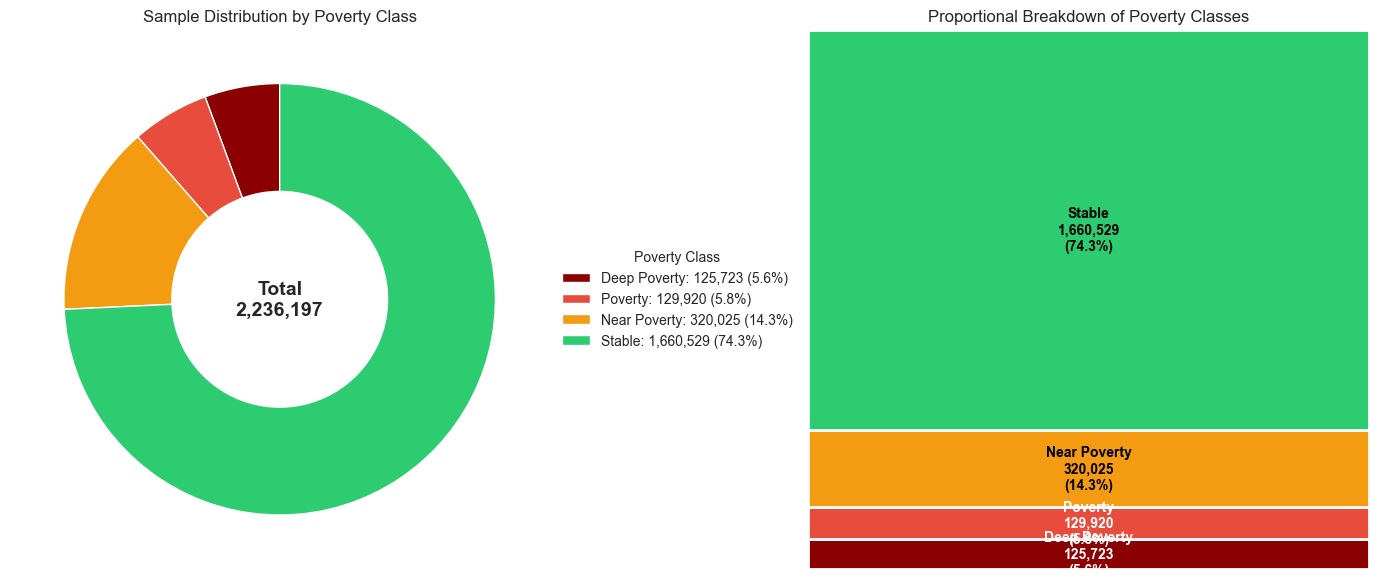


=== Sample Size Summary ===
Total records with valid POVPIP: 2,236,197

Breakdown by poverty class:
  Deep Poverty   :    125,723 (  5.6%)
  Poverty        :    129,920 (  5.8%)
  Near Poverty   :    320,025 ( 14.3%)
  Stable         :  1,660,529 ( 74.3%)


In [70]:
# Sample Size Overview: Class Breakdown with Counts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Donut chart of poverty class distribution
class_counts = df_analysis['poverty_class'].value_counts().reindex(class_order)
colors = [class_colors[c] for c in class_order]

wedges, texts, autotexts = axes[0].pie(class_counts.values, labels=None, autopct='', 
                                        colors=colors, startangle=90, 
                                        wedgeprops=dict(width=0.5, edgecolor='white'))

# Add center text
total = class_counts.sum()
axes[0].text(0, 0, f'Total\n{total:,}', ha='center', va='center', fontsize=14, fontweight='bold')

# Custom legend with counts and percentages
legend_labels = [f'{cls}: {cnt:,} ({cnt/total*100:.1f}%)' for cls, cnt in zip(class_order, class_counts.values)]
axes[0].legend(wedges, legend_labels, title='Poverty Class', loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Sample Distribution by Poverty Class', fontsize=12)

# 2. Treemap-style breakdown
from matplotlib.patches import Rectangle

# Prepare data for treemap
class_data = pd.DataFrame({
    'Class': class_order,
    'Count': class_counts.values,
    'Pct': class_counts.values / total * 100
})

# Simple stacked bar to show proportions
bottom = 0
for i, row in class_data.iterrows():
    rect_height = row['Pct']
    axes[1].add_patch(Rectangle((0, bottom), 1, rect_height, 
                                  facecolor=class_colors[row['Class']], 
                                  edgecolor='white', linewidth=2))
    # Add label
    if rect_height > 5:  # Only label if big enough
        axes[1].text(0.5, bottom + rect_height/2, 
                     f"{row['Class']}\n{row['Count']:,}\n({row['Pct']:.1f}%)", 
                     ha='center', va='center', fontsize=10, fontweight='bold',
                     color='white' if row['Class'] in ['Deep Poverty', 'Poverty'] else 'black')
    bottom += rect_height

axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 100)
axes[1].axis('off')
axes[1].set_title('Proportional Breakdown of Poverty Classes', fontsize=12)

plt.tight_layout()
plt.savefig('EDA_data/poverty_class_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Sample Size Summary ===")
print(f"Total records with valid POVPIP: {total:,}")
print("\nBreakdown by poverty class:")
for cls in class_order:
    cnt = class_counts[cls]
    pct = cnt / total * 100
    print(f"  {cls:<15}: {cnt:>10,} ({pct:>5.1f}%)")

In [71]:
income_feats = ['PINCP','PERNP','WAGP','SEMP','INTP','RETP','SSP','SSIP','PAP','OIP']
detailed_excl = ['DDRS','DEAR','DEYE','DOUT','DPHY','DREM','HINS1','HINS2','HINS3','HINS4','HINS5','HINS6','HINS7','NWLK','NWLA','NWAB','NWAV','NWRE','RACWHT','RACASN','RACSOR','RACBLK','RACNH','RACPI','RACAIAN','RAC2P','RAC3P','ANC','ANC1P','ANC2P','RACNUM']
all_excl = set(income_feats + detailed_excl)
if 'corr_df' in dir() and len(corr_df)>0:
    high_corr = corr_df[corr_df['abs_corr']>=0.08]['column'].tolist()
    high_corr = [f for f in high_corr if f not in all_excl]
    if 'variance_df' in dir():
        low_var_cols = variance_df[variance_df['mode_pct']>95]['column'].tolist()
        high_corr = [f for f in high_corr if f not in low_var_cols]
    domain = ['AGEP','SEX','RAC1P','CIT','NATIVITY','MIG','PUMA', 'year'] #year = year of census record is in
    recommended = list(set(high_corr + domain) - all_excl)
    print(f'RECOMMENDED ({len(recommended)}): {sorted(recommended)}')
    
    # Create DataFrame with column, label, and values_json
    rec_df = pd.DataFrame({'column': sorted(recommended)})
    if 'df_dict_clean' in dir() and {'column', 'label', 'values_json'}.issubset(df_dict_clean.columns):
        rec_df = rec_df.merge(df_dict_clean[['column', 'label', 'values_json']], on='column', how='left')

    print(f'Saved to: {OUTPUT_DIR}/recommended_features.csv')

RECOMMENDED (23): ['AGEP', 'CIT', 'DIS', 'ESR', 'HICOV', 'LANX', 'MAR', 'MIG', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'PRIVCOV', 'PUBCOV', 'PUMA', 'RAC1P', 'RC', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'year']
Saved to: EDA_data/recommended_features.csv


In [72]:
# ============================================================
# "FINAL RECOMMENDED FEATURE SET" + Multicollinearity check
# ============================================================

# ---------- helpers ----------
def _shorten(s, n=55):
    s = "" if pd.isna(s) else str(s)
    return (s[: n - 3] + "...") if len(s) > n else s

def _fmt_r(x):
    if pd.isna(x):
        return "r=   NA"
    return f"r={x:+.3f}"

if "recommended" not in globals():
    recommended_path = f"{OUTPUT_DIR}/recommended_features.csv"
    recommended = pd.read_csv(recommended_path)["column"].tolist()

recommended = sorted(list(dict.fromkeys(recommended)))

# Use the df with valid POVPIP for correlation/corr-matrix work
df_valid = df[df["POVPIP"].notna()].copy()

# Quick lookup: label + correlation-with-target from corr_df
label_map = {}
if "df_dict_clean" in globals() and {"column", "label"}.issubset(df_dict_clean.columns):
    label_map = dict(zip(df_dict_clean["column"], df_dict_clean["label"]))

corr_map = {}
if "corr_df" in globals() and {"column", "correlation"}.issubset(corr_df.columns):
    corr_map = dict(zip(corr_df["column"], corr_df["correlation"]))


var_to_group = {
    # Demographics
    "AGEP": "Demographics",
    "CIT": "Demographics",
    "MAR": "Demographics",
    "MIG": "Demographics",
    "MSP": "Demographics",
    "NATIVITY": "Demographics",
    "SEX": "Demographics",

    # Race/Ethnicity
    "HISP": "Race/Ethnicity",
    "RAC1P": "Race/Ethnicity",

    # Education
    "SCHL": "Education",

    # Employment
    "ESR": "Employment",
    "OCCP": "Employment",
    "WKHP": "Employment",
    "WKL": "Employment",
    "WRK": "Employment",

    # Health Insurance
    "HICOV": "Health Insurance",
    "PRIVCOV": "Health Insurance",
    "PUBCOV": "Health Insurance",

    # Disability
    "DIS": "Disability",

    # Geography
    "POBP": "Geography",
    "PUMA" : "Geography",

    # Household
    "RC": "Household",
    "LANX" : "Household",
}

group_order = [
    "Demographics",
    "Race/Ethnicity",
    "Education",
    "Employment",
    "Health Insurance",
    "Disability",
    "Geography",
    "Household",
    "Other",
]

def get_group(v):
    return var_to_group.get(v, "Other")
    
rows = []
for v in recommended:
    rows.append(
        {
            "group": get_group(v),
            "column": v,
            "r": corr_map.get(v, np.nan),
            "label": label_map.get(v, ""),
        }
    )

out_df = pd.DataFrame(rows)
out_df["group"] = pd.Categorical(out_df["group"], categories=group_order, ordered=True)
out_df = out_df.sort_values(["group", "column"]).reset_index(drop=True)

# ---------- print: FINAL RECOMMENDED FEATURE SET ----------
N = len(recommended)
bar = "=" * 60
print(bar)
print(f"FINAL RECOMMENDED FEATURE SET: {N} features")
print(bar)
print()

for g in group_order:
    gdf = out_df[out_df["group"] == g]
    if gdf.empty:
        continue

    print(f"{g} ({len(gdf)}):")
    for _, r in gdf.iterrows():
        col = r["column"]
        rtxt = _fmt_r(r["r"])
        lbl = _shorten(r["label"], n=60)
        print(f"  {col:<12} | {rtxt:<8} | {lbl}")
    print()

# ---------- MULTICOLLINEARITY CHECK (|r| > 0.80) ----------
print(bar)
print("MULTICOLLINEARITY CHECK")
print(bar)
print()

# correlation matrix among recommended (numeric-coded ACS vars are fine)
cols_in_df = [c for c in recommended if c in df_valid.columns]
if len(cols_in_df) < 2:
    print("Not enough recommended columns found in df_valid to compute correlations.")
else:
    corr_mat = df_valid[cols_in_df].corr()

    # collect high-correlation pairs from upper triangle
    thr = 0.80
    pairs = []
    cm = corr_mat.copy()
    upper = np.triu(np.ones(cm.shape), k=1).astype(bool)
    cm_upper = cm.where(upper)

    for c1 in cm_upper.columns:
        s = cm_upper[c1].dropna()
        for c0, r in s.items():
            if abs(r) > thr:
                pairs.append((c0, c1, r))

    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

    if not pairs:
        print(f"No highly correlated pairs found (|r| > {thr:.2f}).")
    else:
        print(f"Warning: {len(pairs)} highly correlated pairs (|r| > {thr:.2f}):")
        for a, b, r in pairs:
            print(f"  {a} <-> {b}: r={r:.3f}")


FINAL RECOMMENDED FEATURE SET: 23 features

Demographics (7):
  AGEP         | r=+0.091 | Age
  CIT          | r=-0.083 | Citizenship status
  MAR          | r=-0.218 | Marital status
  MIG          | r=-0.046 | Mobility status (lived here 1 year ago)
  MSP          | r=-0.244 | Married, spouse present/spouse absent
  NATIVITY     | r=-0.067 | Nativity
  SEX          | r=-0.031 | Sex

Race/Ethnicity (1):
  RAC1P        | r=-0.125 | Recoded detailed race code (Note: due to space restrictio...

Education (1):
  SCHL         | r=+0.262 | Educational attainment

Employment (5):
  ESR          | r=-0.250 | Employment status recode
  OCCP         | r=-0.284 | Occupation recode for 2018 and later based on 2018 OCC codes
  WKHP         | r=+0.217 | Usual hours worked per week past 12 months
  WKL          | r=-0.245 | When last worked
  WRK          | r=-0.266 | Worked last week

Health Insurance (3):
  HICOV        | r=-0.135 | Health insurance coverage recode
  PRIVCOV      | r=-0.469 | Priv

# Data Preprocessing

In [101]:
# splitting by year to prevent leakage first
cols_to_use = list(rec_df["column"].unique()) + ["POVPIP"] + ["poverty_risk_score"] + ["CA_Region"]
train_df = df_analysis.loc[
    df_analysis['year'] < 2024,
    df_analysis.columns.intersection(cols_to_use)
].copy()
train_df.to_csv('../3_Data_Preprocessing/preprocessing_data/train_data_final_feat_no_preprocessing.csv', index=False)

test_df = df_analysis[df_analysis['year'] == 2024].copy()
test_df.to_csv('../3_Data_Preprocessing/preprocessing_data/test_data_final_feat_no_preprocessing.csv', index=False)
train_df


,PUMA,AGEP,CIT,LANX,MAR,MIG,SCHL,SEX,WKHP,WKL,...,OCCP,POBP,POVPIP,PRIVCOV,PUBCOV,RAC1P,RC,year,poverty_risk_score,CA_Region
1,7306,18,1,1.0,5,1.0,14.0,2,NaN,3.0,...,NaN,6,0.0,2,2,1,NaN,2018,3.0,Los Angeles
2,3755,69,1,2.0,1,1.0,17.0,1,NaN,3.0,...,NaN,6,110.0,2,1,9,NaN,2018,1.0,Central Valley
3,7319,25,1,2.0,5,1.0,1.0,1,NaN,3.0,...,NaN,4,0.0,1,1,1,NaN,2018,3.0,Los Angeles
7,8507,65,1,1.0,5,1.0,22.0,1,8.0,1.0,...,2040.0,6,144.0,2,1,1,NaN,2018,1.0,Los Angeles
8,5909,55,1,1.0,5,1.0,16.0,2,NaN,3.0,...,NaN,6,56.0,2,1,6,NaN,2018,2.0,Central Coast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928453,6712,43,1,2.0,1,1.0,22.0,1,50.0,1.0,...,1320.0,6,501.0,1,1,1,0.0,2023,0.0,Central Coast
1928454,6712,11,1,2.0,5,1.0,8.0,2,NaN,NaN,...,NaN,6,501.0,1,2,1,1.0,2023,0.0,Central Coast
1928455,6712,9,1,2.0,5,1.0,6.0,1,NaN,NaN,...,NaN,6,501.0,1,2,1,1.0,2023,0.0,Central Coast
1928456,1312,33,4,1.0,3,1.0,21.0,2,40.0,1.0,...,1050.0,508,501.0,1,2,6,0.0,2023,0.0,Northern CA/Sierras


In [102]:
train_df.columns

Index(['PUMA', 'AGEP', 'CIT', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP',
       'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
       'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'RC', 'year',
       'poverty_risk_score', 'CA_Region'],
      dtype='str')

## EDA Summary and Key Findings

### Target Variable (POVPIP) - Multiclass Classification
We use a 4-class classification based on income-to-poverty ratio (POVPIP):

| Class | POVPIP Range | Description |
|-------|--------------|-------------|
| **Deep Poverty** | 0-50 | Severe economic hardship, less than half the poverty threshold |
| **Poverty** | 51-100 | Below poverty line |
| **Near Poverty** | 101-200 | Above poverty line but vulnerable, limited financial buffer |
| **Stable** | 201+ | More than twice the poverty threshold, relatively secure |

### Class Distribution
- Significant class imbalance exists - "Stable" is the majority class
- Deep Poverty and Poverty combined represent approximately 11% of the population
- Near Poverty represents an important "at risk" population that may benefit from early intervention

### Feature Selection Philosophy
We focused on identifying **risk factors** that predict poverty susceptibility, NOT income proxies:

1. **Excluded ALL income variables** (PINCP, PERNP, WAGP, RETP, SSP, SSIP, PAP, etc.)
   - POVPIP is calculated from income, so including income = data leakage
   - Goal is to identify at-risk individuals using non-income factors

2. **Used Summary Recodes Only** (avoid multicollinearity)
   - DIS instead of DDRS, DEAR, DEYE, DOUT, DPHY, DREM
   - HICOV/PRIVCOV/PUBCOV instead of HINS1-7
   - ESR instead of NWLK, NWLA, NWAB

3. **Simplified Race Variables**
   - Keep RAC1P (detailed race code)
   - Drop redundant binary flags (RACWHT, RACASN, RACSOR, etc.)

### Final Feature Categories
- **Health Insurance**: HICOV, PRIVCOV, PUBCOV - strongest predictors
- **Employment**: ESR, WRK, WKL, WKHP, OCCP
- **Education**: SCHL - educational attainment
- **Demographics**: AGEP, SEX, MAR, MSP, CIT, NATIVITY
- **Race/Ethnicity**: RAC1P, HISP
- **Disability**: DIS

### Multiclass Modeling Considerations
For model training, consider:
- **Class weights** (sklearn: `class_weight='balanced'`) to handle imbalance
- **Ordinal regression** since classes have natural ordering (Deep Poverty < Poverty < Near Poverty < Stable)
- **Metrics**: Use macro F1-score or weighted F1-score to account for class imbalance
- **Focus on recall** for poverty classes to minimize false negatives (missing at-risk individuals)
- Consider combining Deep Poverty + Poverty vs Near Poverty vs Stable for a 3-class simplified version if needed